In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode, pearsonr
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

%matplotlib inline

In [4]:
# 原始数据
df = pd.read_csv('./data/round2_train.txt', sep=' ', na_values='-1')
dfA = pd.read_csv('./data/round2_ijcai_18_test_a_20180425.txt', sep=' ', na_values='-1')
originDf = pd.concat([df,dfA], ignore_index=True)

print(df.info())
print(dfA.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10432036 entries, 0 to 10432035
Data columns (total 27 columns):
instance_id                  int64
item_id                      int64
item_category_list           object
item_property_list           object
item_brand_id                float64
item_city_id                 float64
item_price_level             int64
item_sales_level             float64
item_collected_level         int64
item_pv_level                int64
user_id                      int64
user_gender_id               float64
user_age_level               float64
user_occupation_id           float64
user_star_level              float64
context_id                   int64
context_timestamp            int64
context_page_id              int64
predict_category_property    object
shop_id                      int64
shop_review_num_level        int64
shop_review_positive_rate    float64
shop_star_level              int64
shop_score_service           float64
shop_score_delivery     

In [5]:
# 原始数据各日期数据量及转化率
tempDf = df.drop_duplicates()
tempDf['context_timestamp'] = tempDf['context_timestamp'].map(lambda x: datetime.fromtimestamp(x))
tempDf['date'] = pd.to_datetime(tempDf.context_timestamp.dt.date)
print(tempDf['date'].value_counts())
tempDf2 = pd.pivot_table(tempDf, index=['date'], values='is_trade', aggfunc=np.mean)
print(tempDf2)

2018-09-06    1934443
2018-09-01    1340697
2018-09-02    1289476
2018-09-03    1236828
2018-09-05    1200219
2018-08-31    1195557
2018-09-04    1157641
2018-09-07    1077175
Name: date, dtype: int64
            is_trade
date                
2018-08-31  0.012838
2018-09-01  0.013609
2018-09-02  0.013290
2018-09-03  0.012378
2018-09-04  0.011367
2018-09-05  0.009772
2018-09-06  0.005498
2018-09-07  0.046089


初步打算：倒数第二天做统计，当天做训练

前5天视为平常日期，抽样0.3方便做数据分析

In [ ]:
# 对数据做抽样后保存
df = pd.read_csv('./data/round2_train.txt', sep=' ')
df = df.sample(frac=0.3)
df.to_csv('./data/round2_train_sample.txt', sep=' ', index=False)

In [3]:
# 抽样后数据读取
# df1 = pd.read_csv('./data/round2_train_h4_sample.txt', sep=' ', na_values='-1')
# df2 = pd.read_csv('./data/round2_train_t2.txt', sep=' ', na_values='-1')
# df = pd.concat([df1,df2], ignore_index=True)
df = pd.read_csv('./data/round2_train_sample.txt', sep=' ', na_values='-1')

# print(df1.info())
# print(df2.info())
print(df.info())
df = df.sample(frac=0.5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129611 entries, 0 to 3129610
Data columns (total 27 columns):
instance_id                  int64
item_id                      int64
item_category_list           object
item_property_list           object
item_brand_id                float64
item_city_id                 float64
item_price_level             int64
item_sales_level             float64
item_collected_level         int64
item_pv_level                int64
user_id                      int64
user_gender_id               float64
user_age_level               float64
user_occupation_id           float64
user_star_level              float64
context_id                   int64
context_timestamp            int64
context_page_id              int64
predict_category_property    object
shop_id                      int64
shop_review_num_level        int64
shop_review_positive_rate    float64
shop_star_level              int64
shop_score_service           float64
shop_score_delivery       

In [4]:
# 单维度转化率评价
def printSingleFeaLine(df, cols):
    tempDf = df.fillna(-9999)
    for c in cols:
        print(tempDf[c].value_counts())
        plt.figure(figsize=(15,5))
        sns.pointplot(x=c, y='is_trade', data=tempDf, hue='dataset',dodge=True)

In [5]:
# 计算转化皮尔森系数
def getFeaPearsonr(df, cols):
    resultDf = pd.DataFrame(index=cols, columns=['pearsonr','p_values'])
    for c in cols:
        tempDf = df.dropna(subset=[c])
        result = pearsonr(tempDf[c].values, tempDf['is_trade'].values)
        resultDf.loc[c,:] = result
    return resultDf

In [6]:
# 矩估计法计算贝叶斯平滑参数
def countBetaParamByMME(inputArr):
    EX = inputArr.mean()
    EX2 = (inputArr ** 2).mean()
    alpha = (EX*(EX-EX2)) / (EX2 - EX**2)
    beta = alpha * (1/EX - 1)
    return alpha,beta

# 对numpy数组进行贝叶斯平滑处理
def biasSmooth(aArr, bArr, method='MME', alpha=None, beta=None):
    ratioArr = aArr / bArr
    if method=='MME':
        alpha,beta = countBetaParamByMME(ratioArr[ratioArr==ratioArr])
    resultArr = (aArr+alpha) / (bArr+alpha+beta)
    return resultArr

In [7]:
# 转化数据集字段格式，拆分组合特征
def formatDf(df):
    df.drop_duplicates(inplace=True)
    df['context_timestamp'] = df['context_timestamp'].map(lambda x: datetime.fromtimestamp(x))
    tempDf = df.drop_duplicates(subset=['item_id'])[['item_id','item_category_list','item_property_list']]
    tempDf['item_category_list'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x.split(';'))
    tempDf['item_category0'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[0])
    tempDf['item_category1'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[1] if len(x)>1 else np.nan)
    tempDf['item_category2'] = tempDf[tempDf.item_category_list.notnull()]['item_category_list'].map(lambda x: x[2] if len(x)>2 else np.nan)
    tempDf['item_property_list'] = tempDf[tempDf.item_property_list.notnull()]['item_property_list'].map(lambda x: x.split(';'))
    df = df.drop(['item_category_list','item_property_list'], axis=1).merge(tempDf, how='left', on='item_id')
    df['predict_category_property'] = df[df.predict_category_property.notnull()]['predict_category_property'].map(
        lambda x: {kv.split(':')[0]:(kv.split(':')[1].split(',') if kv.split(':')[1]!='-1' else []) for kv in x.split(';')})
    df['user_item'] = df['user_id'].astype('str') + '_' + df['item_id'].astype('str')
    return df

In [8]:
# 添加时间特征
def addTimeFea(df, **params):
    df['hour'] = df.context_timestamp.dt.hour
    df['minute'] = df.context_timestamp.dt.minute
    df['date'] = pd.to_datetime(df.context_timestamp.dt.date)
    return df

In [9]:
# 将数据字段格式化
df = formatDf(df)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564806 entries, 0 to 1564805
Data columns (total 31 columns):
instance_id                  1564806 non-null int64
item_id                      1564806 non-null int64
item_brand_id                1503468 non-null float64
item_city_id                 1563664 non-null float64
item_price_level             1564806 non-null int64
item_sales_level             1558057 non-null float64
item_collected_level         1564806 non-null int64
item_pv_level                1564806 non-null int64
user_id                      1564806 non-null int64
user_gender_id               1524820 non-null float64
user_age_level               1561295 non-null float64
user_occupation_id           1561295 non-null float64
user_star_level              1561295 non-null float64
context_id                   1564806 non-null int64
context_timestamp            1564806 non-null datetime64[ns]
context_page_id              1564806 non-null int64
predict_category_property    156

In [10]:
# 添加时间特征
df = addTimeFea(df)

In [11]:
# 添加数据集标记
df.loc[df.date<'2018-09-05','dataset'] = 0
df.loc[(df.date>='2018-09-05')&(df.date<'2018-09-07'),'dataset'] = 1
df.loc[df.date=='2018-09-07','dataset'] = 2

In [12]:
# 暂时加入测试集数据作全天时间段统计分析
predictDf = pd.read_csv('./data/round2_ijcai_18_test_a_20180425.txt', sep=' ', na_values='-1')
predictDf = predictDf.sample(frac=0.5)
predictDf = formatDf(predictDf)
predictDf = addTimeFea(predictDf)
originDf = pd.concat([df,predictDf], ignore_index=True)

            len                                                         \
date 2018-08-31 2018-09-01 2018-09-02 2018-09-03 2018-09-06 2018-09-07   
hour                                                                     
0      0.021122   0.023045   0.022222   0.021749   0.014709   0.063054   
1      0.008852   0.010399   0.010055   0.009790   0.006776   0.034237   
2      0.005248   0.005454   0.005705   0.006017   0.004048   0.015458   
3      0.003872   0.004138   0.004612   0.004306   0.003055   0.009095   
4      0.004017   0.003918   0.004174   0.004360   0.002966   0.006911   
5      0.005517   0.005613   0.006030   0.006324   0.004437   0.008649   
6      0.015527   0.015663   0.015131   0.016050   0.010979   0.019701   
7      0.028245   0.029915   0.026345   0.027051   0.017858   0.037851   
8      0.032117   0.036031   0.035889   0.037524   0.026143   0.044599   
9      0.038155   0.040169   0.046511   0.047702   0.034469   0.048124   
10     0.044936   0.049386   0.055117 

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


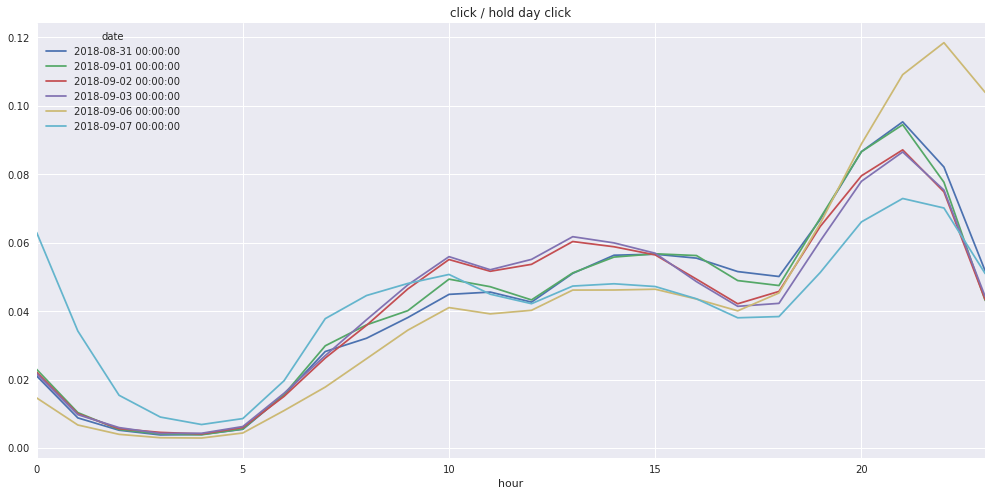

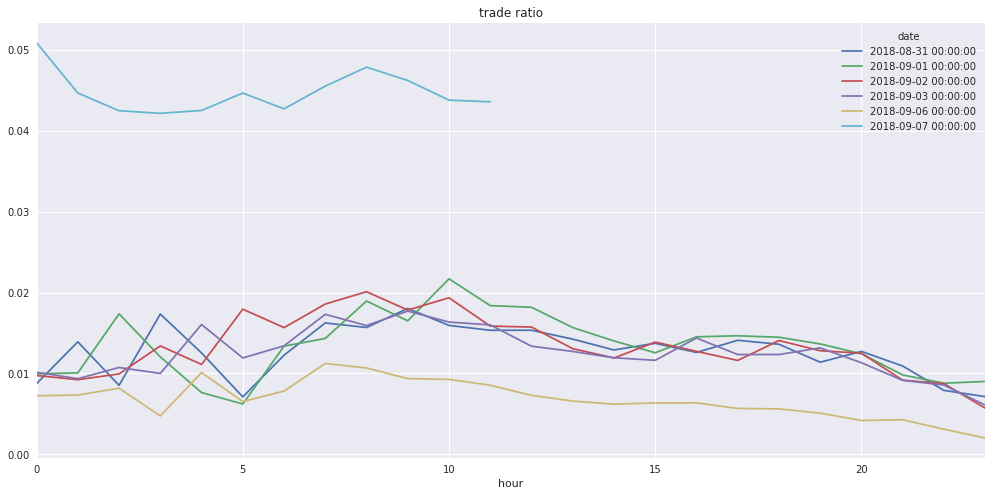

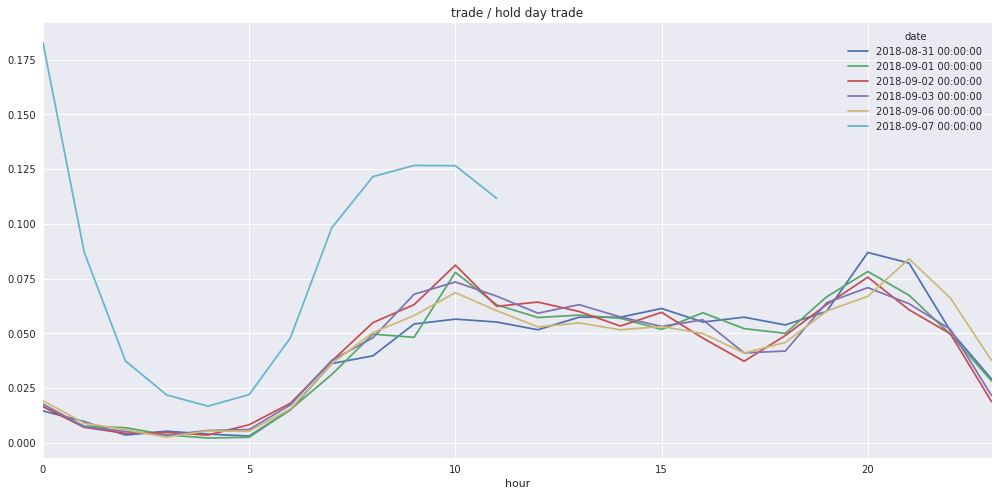

In [13]:
# 查看时段数据分布情况
tempDf = pd.pivot_table(originDf, index='hour', columns='date', values='is_trade', aggfunc=[len,np.mean,np.sum])
tempDf.loc[12:23,pd.IndexSlice['len','2018-09-07']] = tempDf.loc[12:23,pd.IndexSlice['len','2018-09-07']].values.reshape(12) / 0.3
tempDf['len'] = tempDf['len'].apply(lambda x: x / x.sum())
tempDf['sum'] = tempDf['sum'].apply(lambda x: x / x.sum())
print(tempDf)
print(tempDf['len'].plot(figsize=(17,8)))
plt.title('click / hold day click')
print(tempDf['mean'].plot(figsize=(17,8)))
plt.title('trade ratio')
print(tempDf['sum'].plot(figsize=(17,8)))
plt.title('trade / hold day trade')

date  2018-08-31 00:00:00  2018-09-01 00:00:00  2018-09-02 00:00:00  \
hour                                                                  
0                0.008026             0.010608             0.013441   
1                0.011499             0.011498             0.011559   
2                0.016133             0.008866             0.013956   
3                0.009940             0.015425             0.006907   
4                0.011277             0.014072             0.009540   
5                0.006038             0.007746             0.013084   
6                0.010254             0.014006             0.015596   
7                0.012344             0.012929             0.021131   
8                0.014561             0.016619             0.022423   
9                0.016572             0.016606             0.017220   
10               0.017341             0.020404             0.018759   
11               0.016370             0.016657             0.016136   
12    

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


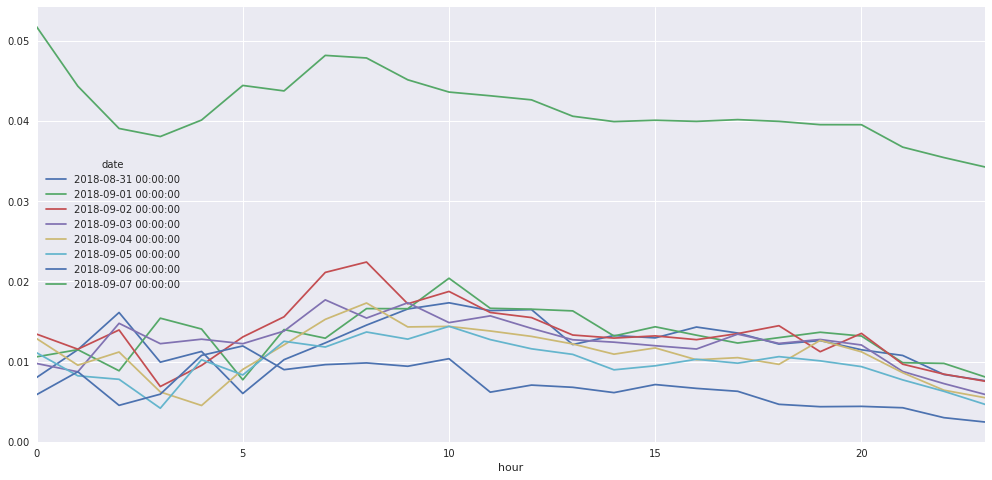

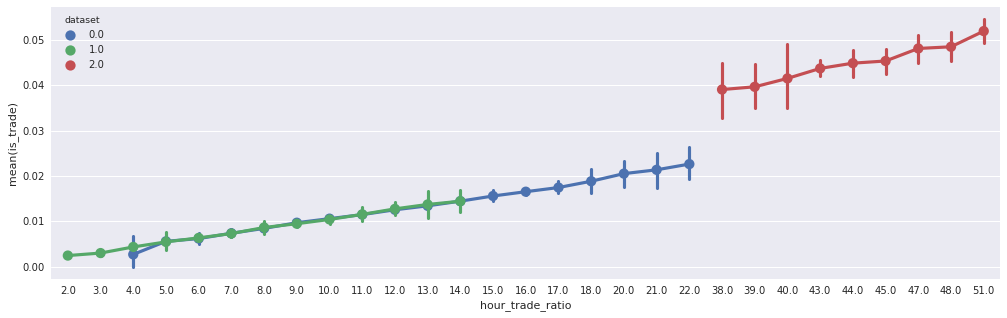

In [17]:
# 小时转化率与转化率关系
# tempDf = df[~df.date.isin(['2018-09-04','2018-09-05','2018-09-06'])]
tempDf = pd.pivot_table(df, index=['hour','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['click','trade']
tempDf['ratio'] = biasSmooth(tempDf['trade'].values,tempDf['click'].values)
tempDf.drop(['click','trade'], axis=1, inplace=True)
tempDf = tempDf.unstack()
tempDf = tempDf['ratio']
tempDf['mean'] = tempDf.iloc[:,:4].apply(lambda x: x.mean(), axis=1)
normalAm = tempDf.loc[(tempDf.index>=9)&(tempDf.index<12)]['mean'].mean()
specialAm = tempDf.loc[(tempDf.index>=9)&(tempDf.index<12)][pd.to_datetime('2018-09-07')].mean()
delta = specialAm - normalAm
tempDf.loc[tempDf.index>11, pd.to_datetime('2018-09-07')] = tempDf.loc[tempDf.index>11, 'mean'] + delta
print(tempDf)
print('normal:',tempDf['mean'].mean())
print('normal am:',tempDf.loc[(tempDf.index>=9)&(tempDf.index<12)]['mean'].mean())
print('special am:',tempDf.loc[(tempDf.index>=9)&(tempDf.index<12)][pd.to_datetime('2018-09-07')].mean())
print('normal pm:',tempDf.loc[tempDf.index>=12]['mean'].mean())
print('special pm:',tempDf.loc[tempDf.index>=12][pd.to_datetime('2018-09-07')].mean())
print('special:',tempDf[pd.to_datetime('2018-09-07')].mean())
print(tempDf.iloc[:,:8].plot(figsize=(17,8)))
tempDf = tempDf.iloc[:,:-1].stack().to_frame()
tempDf.columns = ['hour_trade_ratio']
tempDf.reset_index(inplace=True)
tempDf['date'] = pd.to_datetime(tempDf['date'])
tempDf = df.merge(tempDf, how='left', on=['hour','date'])
# tempDf = df.merge(tempDf, left_on=['hour','date'], right_index=True)
# tempDf.dropna(subset=['hour_trade_ratio'], inplace=True)
print('pearsonr:',pearsonr(tempDf['hour_trade_ratio'].values, tempDf['is_trade'].values))
tempDf['hour_trade_ratio'] = tempDf['hour_trade_ratio'] // 0.001
plt.figure(figsize=(17,5))
sns.pointplot(x='hour_trade_ratio', y='is_trade', hue='dataset', data=tempDf)

In [19]:
set([1,2,3,4,5,6]) - set([1,2])

{3, 4, 5, 6}

10    382803
5     382497
6     382100
7     381959
9     381161
8     380645
4     379662
11    378020
3     376465
2     374276
1     368236
0     362561
Name: minute_hist, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


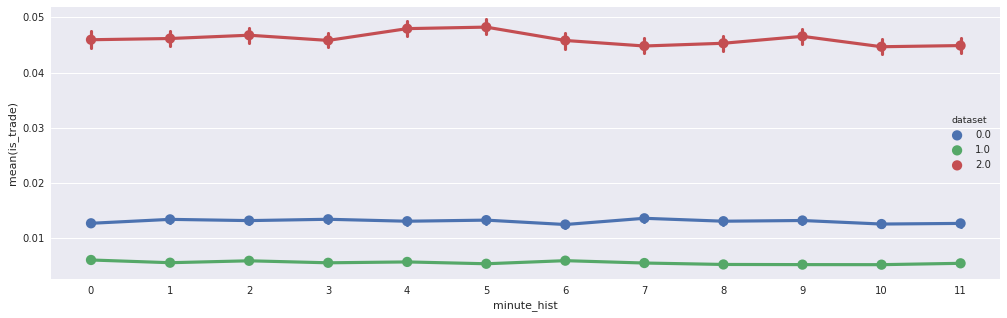

In [14]:
# 考虑分钟是否与转化率有关
tempDf = df.copy()
tempDf['minute_hist'] = tempDf.minute // 5
print(tempDf['minute_hist'].value_counts())
plt.figure(figsize=(17,5))
sns.pointplot(x='minute_hist', y='is_trade', data=tempDf, hue='dataset')
# plt.figure(figsize=(17,5))
# sns.pointplot(x='minute_hist', y='is_trade', data=tempDf, hue='hour2',dodge=True,palette='Paired')

并没有看出分钟上的什么规律，不考虑

cate0: 836752724084922533    2265192
Name: item_category0, dtype: int64
cate2 in cate1:
 597424223456586363     12
5066527928272238333    10
453525480366550911      8
2211060154630359130     7
3613783563199627217     6
5685690139879409547     5
2871729383671301763     4
3089254302947620489     2
6254910033820815248     2
7423553047267511438     2
3434689896486063330     2
Name: item_category1, dtype: int64
11.0    349648
10.0    338337
12.0    315105
9.0     273589
13.0    209409
8.0     203024
7.0     146347
14.0    124816
6.0      94889
5.0      60132
15.0     46697
4.0      35290
3.0      21402
16.0     15479
2.0      10700
0.0      10466
1.0       6426
17.0      3436
Name: item_sales_level, dtype: int64
7     717245
6     607842
8     413288
5     289158
4     102270
9      86033
3      20067
10     15649
2       8955
1       4685
Name: item_price_level, dtype: int64
12    380179
13    370793
11    331297
10    265285
14    255924
9     175124
15    152043
8     112284
7      73343

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


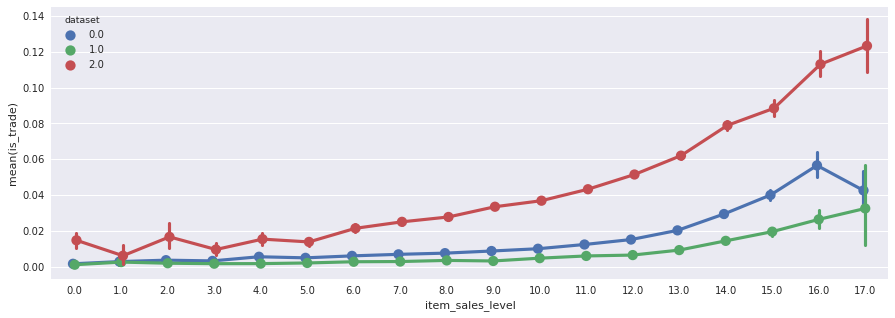

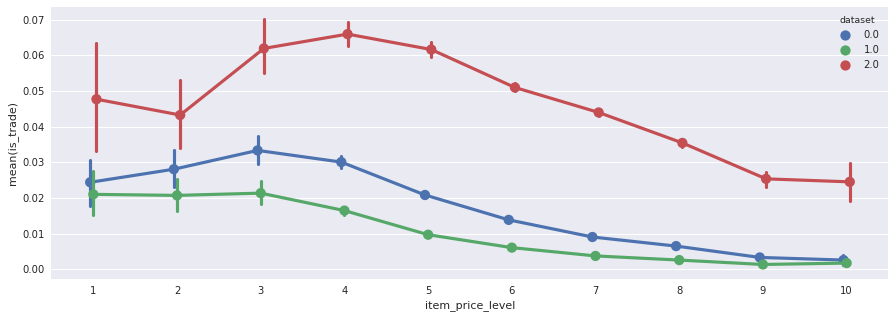

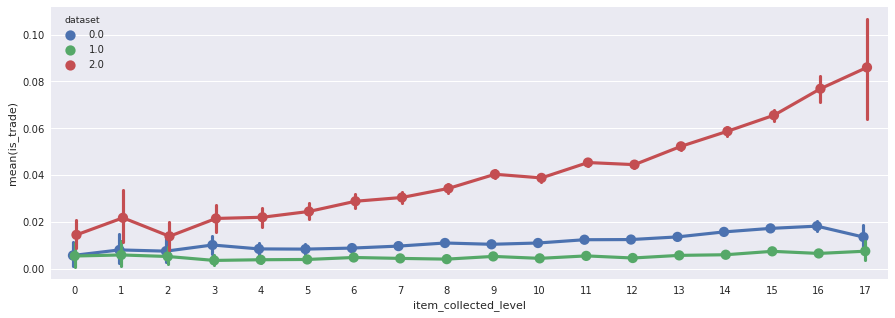

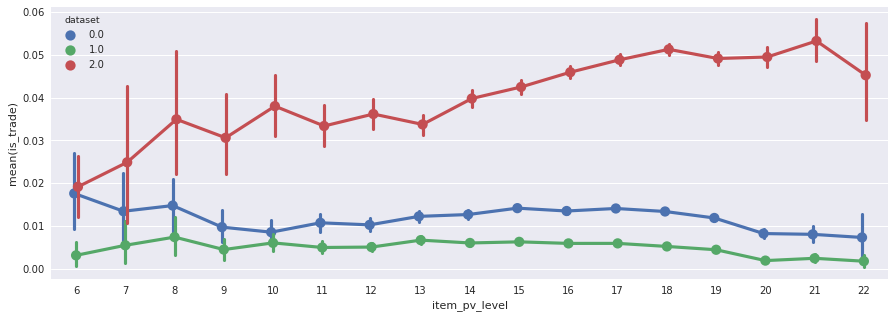

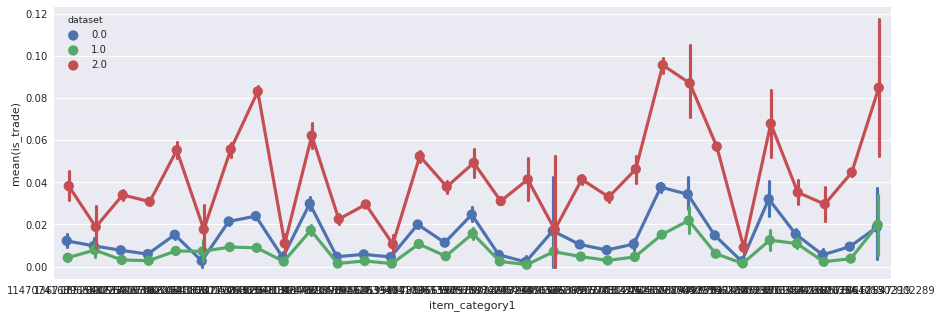

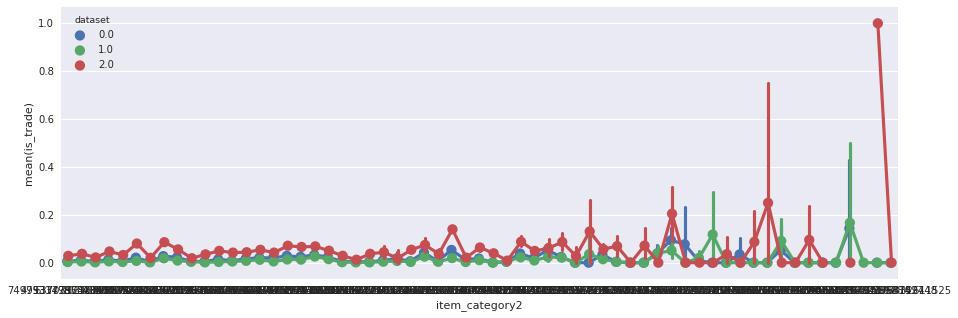

In [26]:
# 商品特征
cols = ['item_sales_level','item_price_level','item_collected_level','item_pv_level','item_category1','item_category2']
print('cate0:',df.item_category0.value_counts())
tempDf = df.dropna(subset=['item_category2']).drop_duplicates(subset=['item_category2'])
print('cate2 in cate1:\n', tempDf['item_category1'].value_counts())
tempDf = df.copy()
tempDf.loc[tempDf.item_sales_level.isnull(), 'item_sales_level'] = 0
tempDf.loc[tempDf.item_price_level<1, 'item_price_level'] = 1
tempDf.loc[tempDf.item_price_level>10, 'item_price_level'] = 10
tempDf.loc[tempDf.item_collected_level>17, 'item_collected_level'] = 17
tempDf.loc[tempDf.item_pv_level<6, 'item_pv_level'] = 6
printSingleFeaLine(tempDf, cols)

+ 销量特征：复赛该特征出现缺失值，根据曲线趋势和缺失数量，基本可以把缺失值当作一种特征值处理
+ 价格特征：LEVEL0商品数量过少，合并进LEVEL1处理。11跟12合并进10
+ 收藏特征：18合并进17
+ 广告特征：1～5合并进6级
+ 类目特征：一级类目增至31个，个别类目数目较少。其中11个有二级类目,且二级类目数较多。因此不适合合并类目统计

 0.0       1738109
 1.0        410770
-9999.0      63596
 2.0         52717
Name: user_gender_id, dtype: int64
 1003.0    823262
 1004.0    583621
 1002.0    363542
 1005.0    258988
 1006.0    126913
 1000.0     54977
 1001.0     24840
 1007.0     23918
-9999.0      5131
Name: user_age_level, dtype: int64
 3006.0    426065
 3003.0    328659
 3005.0    327733
 3007.0    294058
 3004.0    288623
 3002.0    259089
 3000.0    120110
 3008.0    116959
 3001.0     75714
 3009.0     23051
-9999.0      5131
Name: user_star_level, dtype: int64
 2005.0    1317554
 2002.0     782654
 2004.0     127770
 2003.0      32083
-9999.0       5131
Name: user_occupation_id, dtype: int64


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


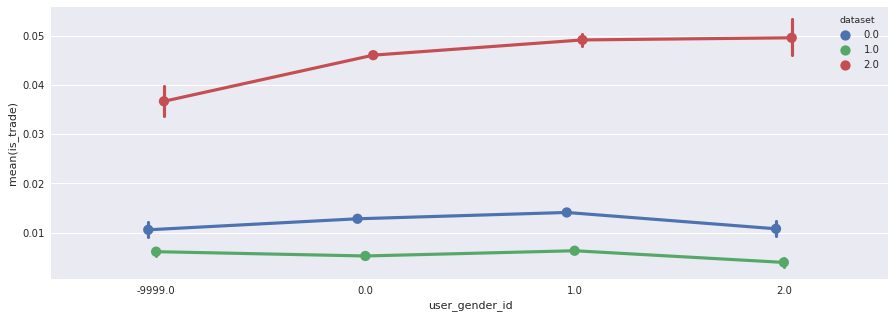

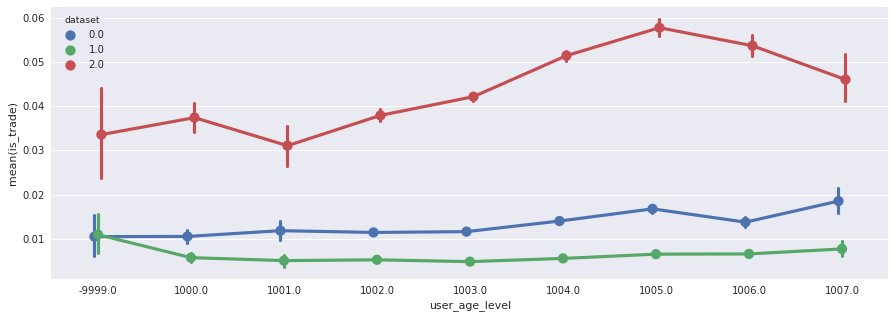

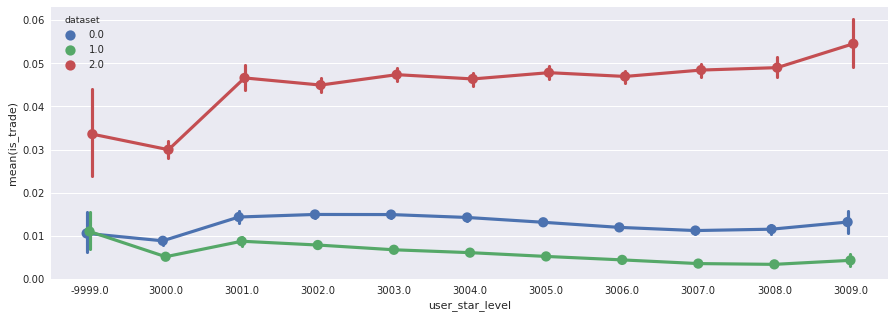

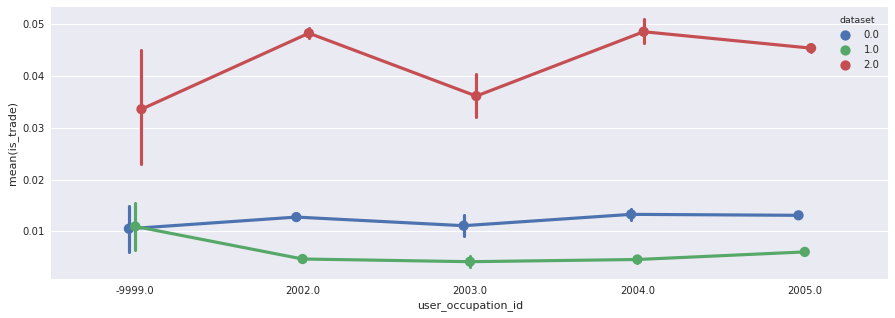

In [28]:
# 用户特征
tempDf = df.copy()
cols = ['user_gender_id','user_age_level','user_star_level','user_occupation_id']
tempDf = df.copy()
tempDf.loc[tempDf.user_gender_id.isnull(), 'user_gender_id'] = -1
# tempDf.loc[tempDf.user_age_level>1006, 'user_age_level'] = 1006
tempDf.loc[tempDf.user_star_level>3009, 'user_star_level'] = 3009
# tempDf.loc[tempDf.user_star_level.isnull(), 'user_star_level'] = 3000
printSingleFeaLine(tempDf, cols)

用户性别：将缺省值当作一个特征值处理

用户星级：超过3009的合并到3009

In [34]:
# 查看用户记录在日期上的分布情况
tempDf = pd.pivot_table(df, index=['user_id'], columns='date', values='is_trade', margins=True, aggfunc=len)
print(tempDf.head(10))
print(tempDf['All'].value_counts())

date            2018-08-31 00:00:00  2018-09-01 00:00:00  2018-09-02 00:00:00  \
user_id                                                                         
1523553916360                   NaN                  1.0                  NaN   
8455785307263                   NaN                  NaN                  NaN   
15213145006378                  NaN                  NaN                  NaN   
25684305694756                  NaN                  NaN                  NaN   
38014406741475                  NaN                  NaN                  NaN   
40480049735387                  NaN                  NaN                  NaN   
50153023443529                  NaN                  NaN                  2.0   
52161064826969                  NaN                  NaN                  1.0   
82470453442674                  NaN                  NaN                  NaN   
86167468089202                  NaN                  NaN                  NaN   

date            2018-09-03 

                             pearsonr      p_values
shop_review_positive_rate  -0.0133958   2.11735e-90
shop_score_service         -0.0258318             0
shop_score_delivery        -0.0289086             0
shop_score_description     -0.0205874  8.43975e-211
shop_star_level           -0.00756538   4.88338e-30
shop_review_num_level     -0.00772551   2.98736e-31
 99.0      1817278
 98.0       313424
 97.0        83938
 96.0        32548
 95.0        10774
 94.0         5469
 93.0         1674
-9999.0         87
Name: shop_review_positive_rate, dtype: int64
 97.0      917693
 96.0      643407
 98.0      454570
 95.0      167971
 99.0       54929
 94.0       19067
 93.0        4771
 92.0        2359
-9999.0       425
Name: shop_score_service, dtype: int64
 97.0      831838
 96.0      650326
 98.0      492743
 95.0      211517
 99.0       48359
 94.0       22728
 93.0        5420
 92.0        1836
-9999.0       425
Name: shop_score_delivery, dtype: int64
 98.0      742883
 97.0      634961

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


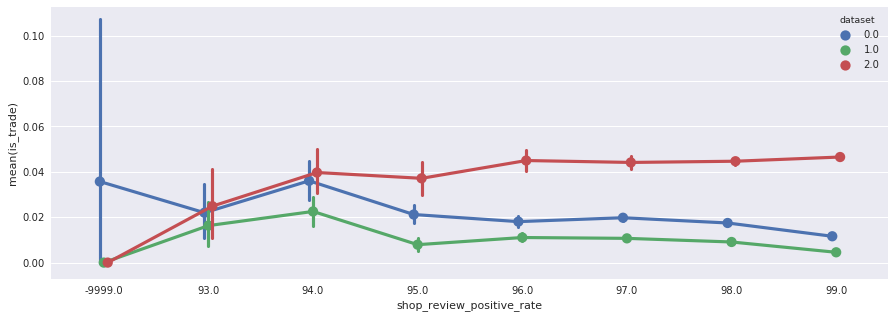

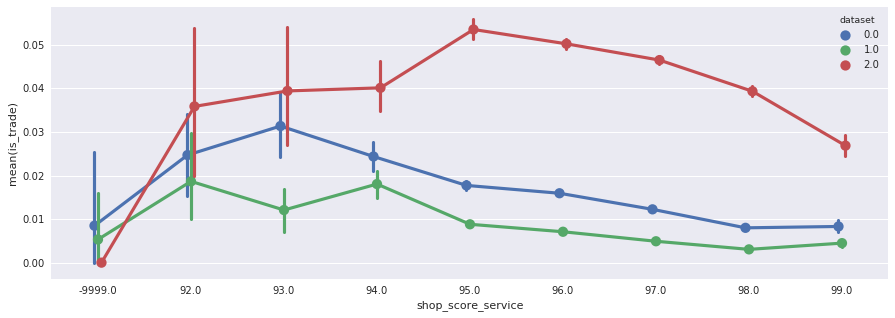

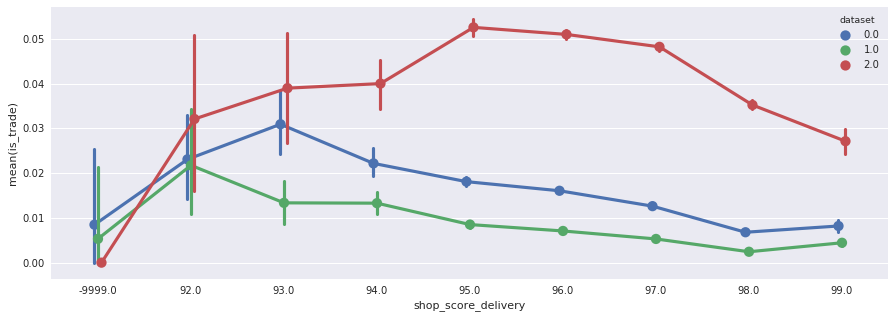

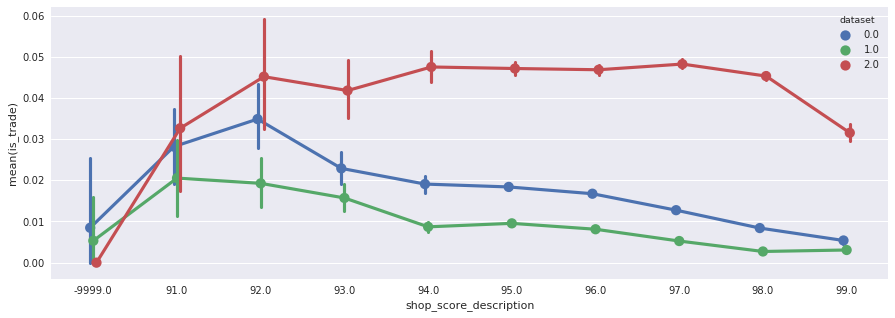

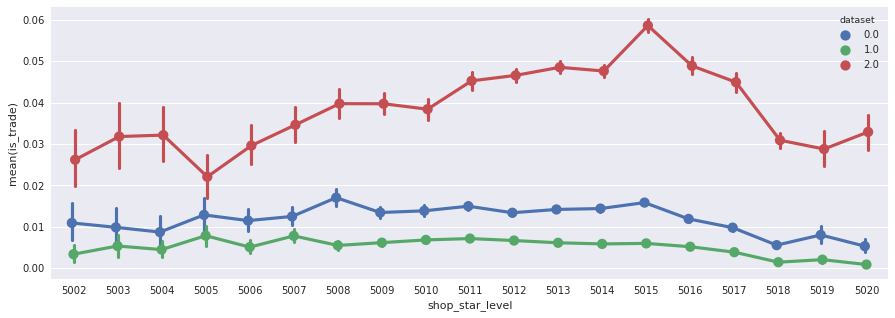

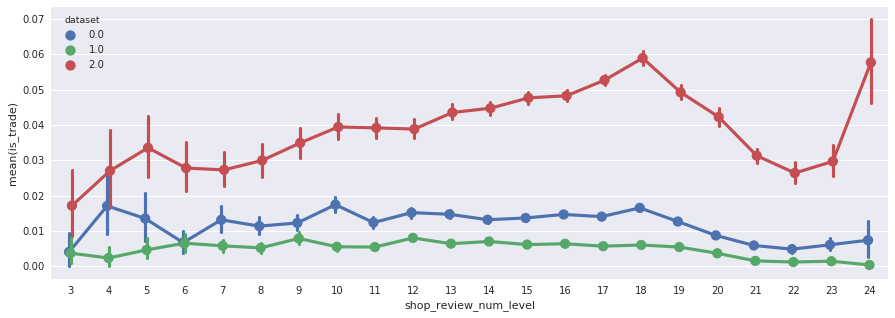

In [10]:
# 店铺特征
tempDf = df.copy()
cols = ['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description','shop_star_level','shop_review_num_level']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[tempDf.shop_star_level<5002, 'shop_star_level'] = 5002
tempDf.loc[tempDf.shop_review_num_level<4, 'shop_review_num_level'] = 3
tempDf.loc[tempDf.shop_review_num_level>23, 'shop_review_num_level'] = 24
tempDf.loc[:,['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] = tempDf[['shop_review_positive_rate','shop_score_service','shop_score_delivery','shop_score_description']] // 0.01
tempDf.loc[tempDf.shop_review_positive_rate<94, 'shop_review_positive_rate'] = 93
tempDf.loc[tempDf.shop_score_service<93, 'shop_score_service'] = 92
tempDf.loc[tempDf.shop_score_delivery<93, 'shop_score_delivery'] = 92
tempDf.loc[tempDf.shop_score_description<92, 'shop_score_description'] = 91
printSingleFeaLine(tempDf, cols)

7号当天的店铺各项评分规律与往常不太一样，但还是有一定的相关性，需要区分对待

In [15]:
# 研究上下文预测类别与商品类目对应关系
tempDf = df.copy()
tempDf['predict_category'] = tempDf['predict_category_property'].dropna().map(lambda x: list(x.keys()))
tempDf2 = tempDf.loc[(tempDf.item_category2.notnull())&(tempDf.predict_category.notnull()),['item_category1','item_category2','predict_category']]
tempDf2['has_cate1'] = tempDf2.apply(lambda x: x.item_category1 in x.predict_category, axis=1)
tempDf2['has_cate2'] = tempDf2.apply(lambda x: x.item_category2 in x.predict_category, axis=1)
print(len(tempDf2))
print('has_cate1:', len(tempDf2[tempDf2.has_cate1]))
print('has_cate2:', len(tempDf2[tempDf2.has_cate2]))
print('has_cate1 & has_cate2:', len(tempDf2[tempDf2.has_cate1 & tempDf2.has_cate2]))

896049
has_cate1: 110306
has_cate2: 761712
has_cate1 & has_cate2: 91828


与初赛不同，复赛带有二级类目的样本，在上下文预测类别中可能含有一级类目或二级类目或者两者皆有，因此需要修改初赛的处理方式

                       pearsonr      p_values
context_page_id      -0.0173041  1.50987e-149
predict_cate_num    0.000386384      0.560898
cate_intersect_num    0.0116681   4.89789e-69
predict_prop_num     0.00630776   6.59712e-13
prop_intersect_num    0.0112801   8.20076e-38
prop_jaccard        -0.00779829   6.33503e-19
prop_jaccard_bias    -0.0106974   3.52904e-34
4001    1212662
4002     210708
4003     155283
4004     119489
4005      93768
4006      76380
4007      63303
4008      52678
4009      44839
4010      38170
4011      32912
4012      29593
4013      25517
4014      22505
4015      19514
4016      17052
4017      15177
4018      13322
4019      11757
4020      10563
Name: context_page_id, dtype: int64
 4.0       472529
 3.0       449864
 2.0       437881
 5.0       357892
 6.0       237210
 7.0       130698
 1.0       110538
 8.0        51101
 9.0        12356
 10.0        4956
-9999.0       167
Name: predict_cate_num, dtype: int64
 2.0       1820160
 1.0        351567
 3.

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


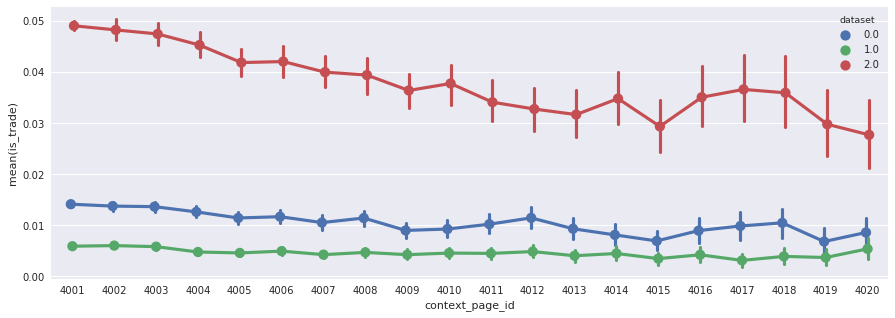

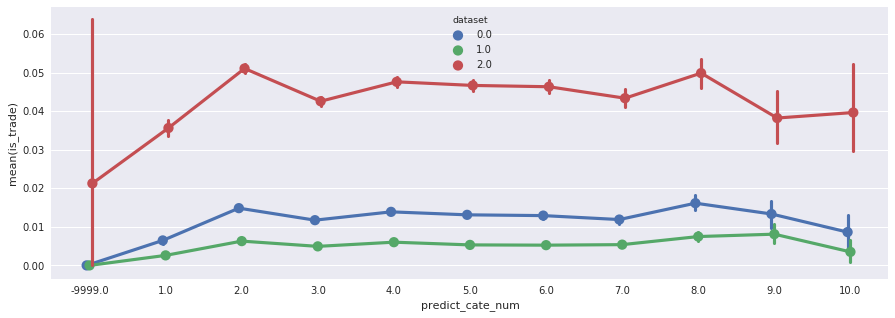

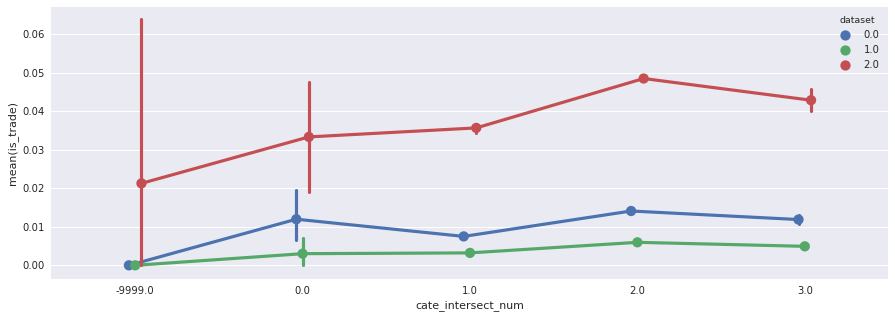

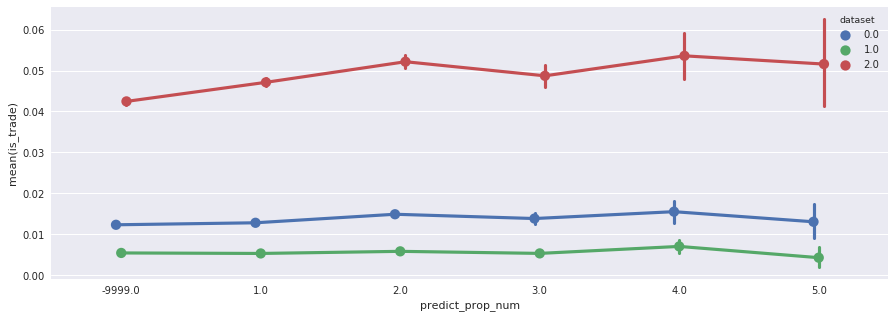

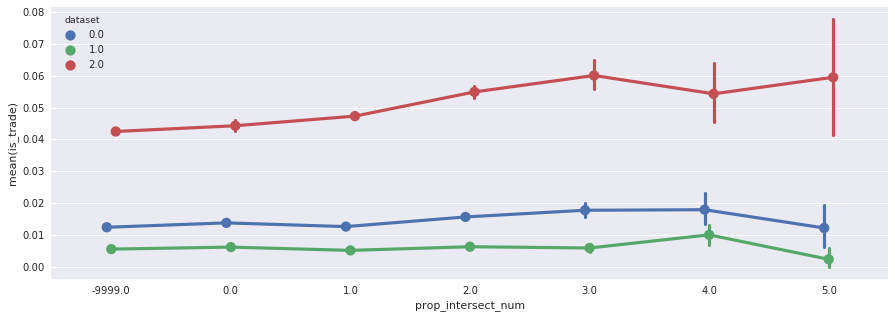

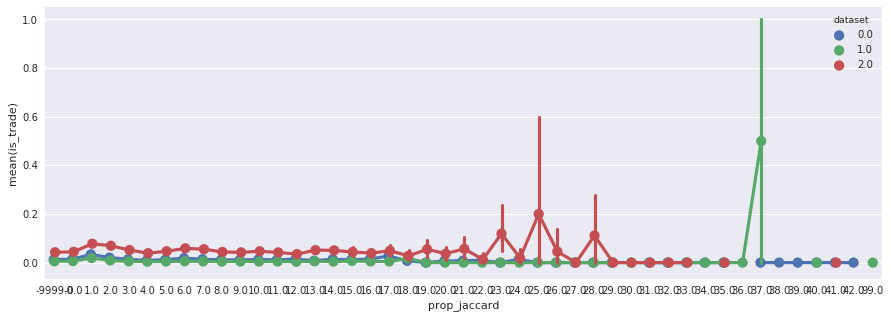

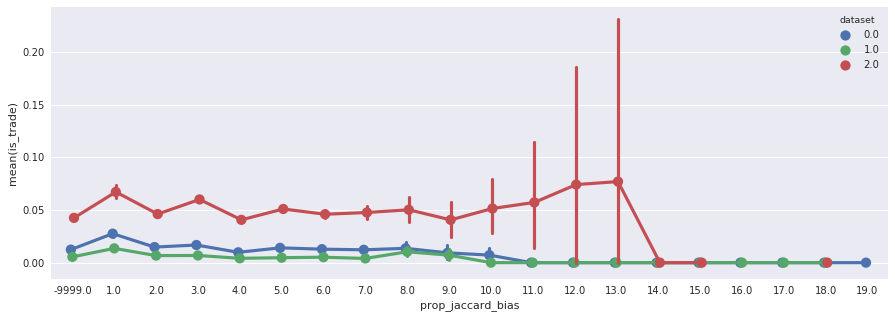

In [32]:
# 上下文特征
tempDf = df.copy()
tempDf['predict_category'] = tempDf['predict_category_property'].dropna().map(lambda x: list(x.keys()))
tempDf['predict_cate_num'] = tempDf['predict_category'].dropna().map(lambda x: len(x))
idx = tempDf[tempDf.predict_category_property.notnull()].index
tempDf.loc[idx,'cate_intersect_num'] = list(map(lambda x: len(np.intersect1d(x[0],x[1])), tempDf.loc[idx, ['item_category_list','predict_category']].values))
tempDf['predict_property'] = [set() for i in range(len(tempDf))]
idx = tempDf[(tempDf.item_category2.notnull())&(tempDf.predict_category_property.notnull())].index
tempDf.loc[idx,'predict_property'] = list(map(lambda x: x[2]|set(x[1][x[0]]) if (x[0] in x[1].keys()) else x[2], tempDf.loc[idx,['item_category2','predict_category_property','predict_property']].values))
idx = tempDf[(tempDf.item_category1.notnull())&(tempDf.predict_category_property.notnull())].index
tempDf.loc[idx,'predict_property'] = list(map(lambda x: x[2]|set(x[1][x[0]]) if (x[0] in x[1].keys()) else x[2], tempDf.loc[idx,['item_category1','predict_category_property','predict_property']].values))
tempDf['predict_property'] = tempDf['predict_property'].map(lambda x: np.nan if len(x)==0 else list(x))
tempDf['predict_prop_num'] = tempDf[tempDf.predict_property.notnull()]['predict_property'].map(lambda x: len(x))
idx = tempDf[(tempDf.predict_property.notnull())&(tempDf.item_property_list.notnull())].index
tempDf.loc[idx, 'prop_intersect_num'] = list(map(lambda x: len(np.intersect1d(x[0],x[1])), tempDf.loc[idx, ['item_property_list','predict_property']].values))
tempDf.loc[idx,'prop_union_num'] = list(map(lambda x: len(np.union1d(x[0],x[1])), tempDf.loc[idx, ['item_property_list','predict_property']].values))
tempDf['prop_jaccard'] = tempDf['prop_intersect_num'] / tempDf['prop_union_num']
tempDf['prop_jaccard_bias'] = biasSmooth(tempDf['prop_intersect_num'].values, tempDf['prop_union_num'].values)

cols = ['context_page_id','predict_cate_num','cate_intersect_num','predict_prop_num','prop_intersect_num','prop_jaccard','prop_jaccard_bias']
print(getFeaPearsonr(tempDf, cols))
tempDf.loc[:,['prop_jaccard','prop_jaccard_bias']] = tempDf[['prop_jaccard','prop_jaccard_bias']] // 0.01
tempDf.loc[tempDf.predict_cate_num>10, 'predict_cate_num'] = 10
tempDf.loc[tempDf.predict_prop_num>5, 'predict_prop_num'] = 5
tempDf.loc[tempDf.prop_intersect_num>5, 'prop_intersect_num'] = 5
printSingleFeaLine(tempDf, cols)
# tempDf.loc[tempDf.predict_prop_num_level>4, 'predict_prop_num_level'] = 4
# tempDf['prop_intersect_num_level'] = tempDf['prop_intersect_num'].values
# tempDf.loc[tempDf.prop_intersect_num_level>3, 'prop_intersect_num_level'] = 3
# tempDf['prop_jaccard'] = biasSmooth(tempDf['prop_intersect_num'].values, tempDf['prop_union_num'].values)
# tempDf.fillna({k:-1 for k in ['predict_prop_num','prop_intersect_num','prop_union_num','prop_jaccard']}, inplace=True)

强相关：
+ 广告页码
+ 预测类目数
+ 预测类目与商品类目交集

弱相关：
+ 预测属性与商品属性交集（缺失值标为-1）

In [41]:
def dataCleaning(df):
    df.loc[df.item_sales_level.isnull(), 'item_sales_level'] = 0
    df.loc[df.item_price_level<1, 'item_price_level'] = 1
    df.loc[df.item_price_level>10, 'item_price_level'] = 10
    df.loc[df.item_collected_level>17, 'item_collected_level'] = 17
    df.loc[df.item_pv_level<6, 'item_pv_level'] = 6
    df.loc[df.shop_star_level<5002, 'shop_star_level'] = 5002
    df.loc[df.shop_review_num_level<4, 'shop_review_num_level'] = 3
    df.loc[df.shop_review_num_level>23, 'shop_review_num_level'] = 24
    df.loc[df.user_gender_id.isnull(), 'user_gender_id'] = -1
    df.loc[df.user_star_level>3009, 'user_star_level'] = 3009
    return df

In [42]:
# 数据清洗
df = dataCleaning(df)

In [43]:
# 按日期统计过去几天的点击数，交易数
def statDateTrade(df, index, statDates=None, skipDates=1):
    tempDf = pd.pivot_table(df, index=index, columns='date', values='is_trade', aggfunc=[len,np.sum])
    if statDates==None:
        for i,dt in enumerate(tempDf.columns.levels[-1][skipDates:]):
            tempDf.loc[:,pd.IndexSlice['show',dt]] = tempDf['len'].iloc[:,:i+skipDates].sum(axis=1)
            tempDf.loc[:,pd.IndexSlice['trade',dt]] = tempDf['sum'].iloc[:,:i+skipDates].sum(axis=1)
    else:
        for i,dt in enumerate(tempDf.columns.levels[-1][statDates:]):
            tempDf.loc[:,pd.IndexSlice['show',dt]] = tempDf['len'].iloc[:,i:i+statDates].sum(axis=1)
            tempDf.loc[:,pd.IndexSlice['trade',dt]] = tempDf['sum'].iloc[:,i:i+statDates].sum(axis=1)
    tempDf = tempDf.stack()
    return tempDf[['show','trade']]

In [44]:
# 统计商品特征
def statItemFea(df, index, prefix):
    itemDf = df.drop_duplicates(['item_id'])
    tempDf = pd.pivot_table(itemDf, index=index, values=['item_sales_level','item_collected_level','item_pv_level','item_price_level'], aggfunc={'item_sales_level':[len,np.sum,np.mean], 'item_collected_level':[np.sum,np.mean], 'item_pv_level':[np.sum,np.mean], 'item_price_level':[np.sum,np.mean]})
    tempDf.columns = [col%prefix for col in ['%s_collected_mean','%s_collected_sum','%s_price_mean','%s_price_sum','%s_pv_mean','%s_pv_sum','%s_item_count','%s_sales_mean','%s_sales_sum']]
    df = df.merge(tempDf, how='left', left_on=index,right_index=True)
    return df

# 按维度统计用户年龄特征
def statUserAge(df, index, prefix):
    tempDf = pd.pivot_table(df, index=index, values=['user_age_level'], aggfunc=[np.mean, np.std])
    tempDf.columns = [colname%prefix for colname in ['%s_age_mean','%s_age_std']]
    df = df.merge(tempDf, how='left', left_on=index, right_index=True)
    df['%s_age_delta'%prefix] = df['user_age_level'] - df['%s_age_mean'%prefix]
    return df

# 按维度统计用户性别特征
def statUserGender(df, index, prefix):
    tempDf = pd.pivot_table(df, index=index, values='is_trade', columns=['user_gender_id'], aggfunc=[len])
    startTime = datetime.now()
    sumCol = tempDf.sum(axis=1)
    aver = tempDf['len'].sum() / sumCol.sum()
    for x in tempDf.columns.levels[-1]:
        tempDf.loc[:,pd.IndexSlice['ratio',x]] = biasSmooth(tempDf['len'][x].values, sumCol.values)
        tempDf.loc[:,pd.IndexSlice['delta',x]] = tempDf.loc[:,pd.IndexSlice['ratio',x]] - aver.loc[x]
    del tempDf['len']
    tempDf = tempDf.stack()
    cols = ['%s_gender_%s'%(prefix,x) for x in ['ratio_delta','ratio']]
    tempDf.columns = cols
    df = df.merge(tempDf, how='left', left_on=[index,'user_gender_id'], right_index=True)
    return df


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                             pearsonr     p_values
user_his_trade_ratio       0.00767251  1.67221e-19
user_last_show_timedelta    0.0108406   6.8099e-42
user_next_show_timedelta    0.0375058            0
user_his_show               -0.010949  5.08818e-38
user_his_trade             0.00557136  5.41197e-11
user_lasthour_show        -0.00689221  6.59621e-18
user_lastdate_show         -0.0113769  0.000211839
user_lastdate_trade         0.0168252   4.2843e-08
user_lastdate_trade_ratio    0.016456  8.39263e-08
 26.0      1139328
-9999.0     178800
 2.0        144262
 1.0         53648
 0.0         46307
 31.0         2461
Name: user_his_trade_ratio, dtype: int64
30.0    1309287
0.0       60670
1.0       42721
2.0       27908
3.0       20075
4.0       15114
5.0       11814
6.0        9415
7.0        7826
8.0        6474
9.0        5741
10.0       4891
11.0       4360
12.0       3799
13.0       3451
14.0       3203
15.0       2913
16.0       2634
17.0       2452
18.0       2277
19.0       2086

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


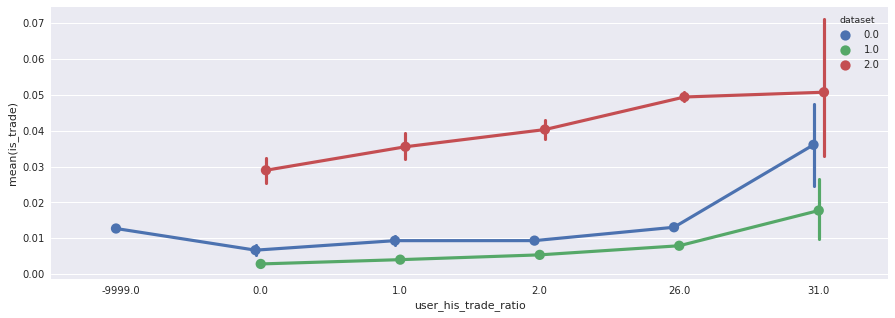

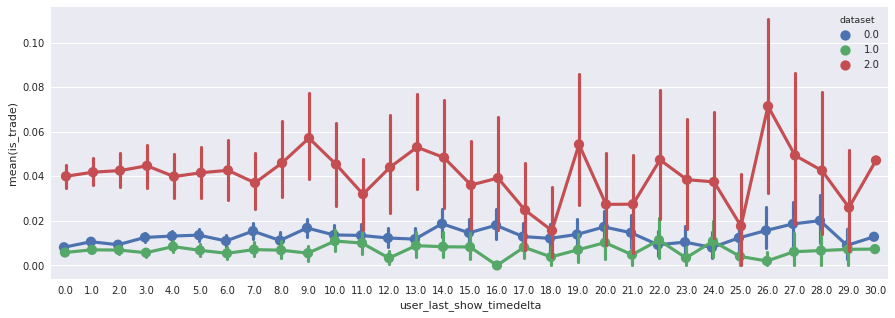

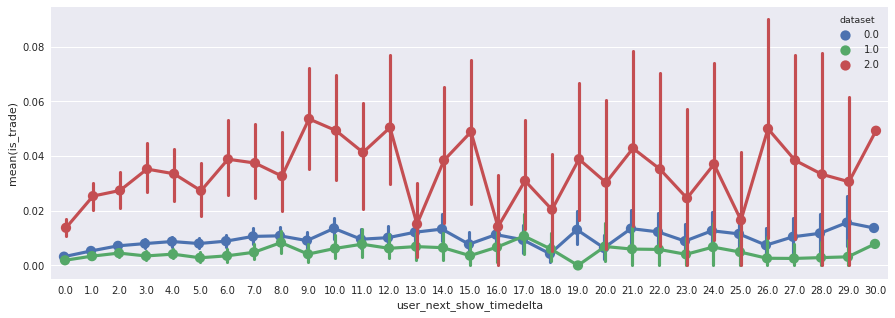

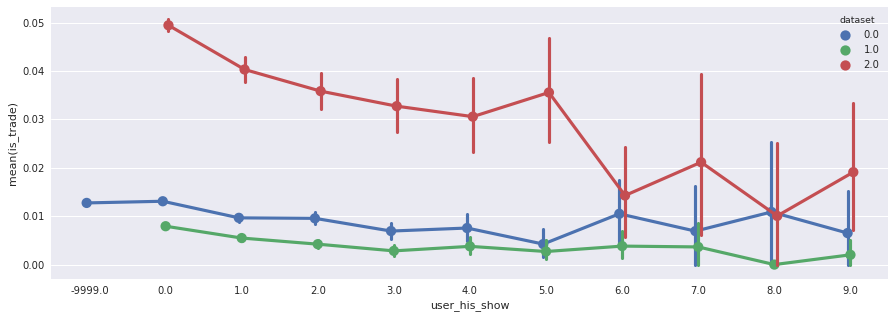

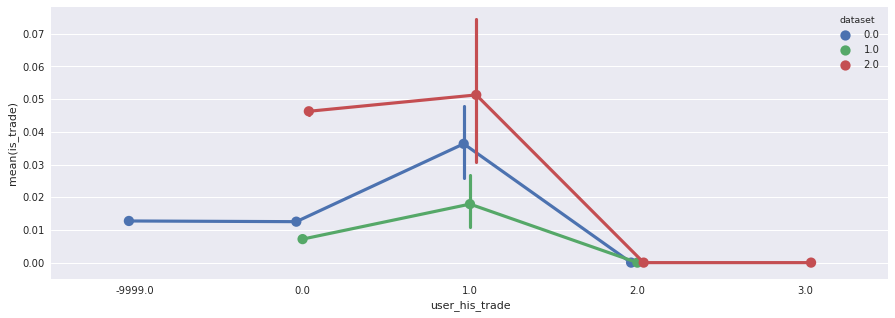

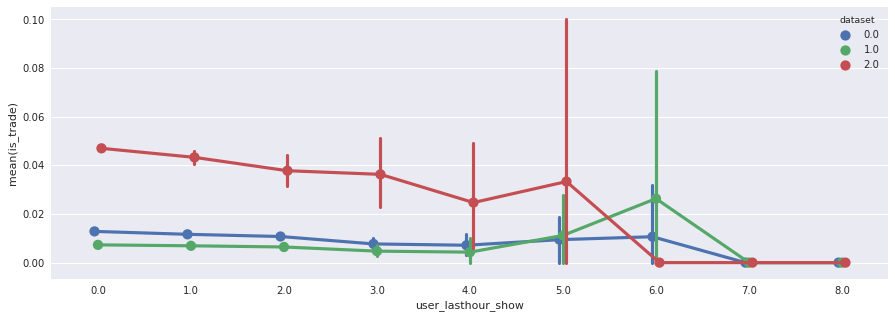

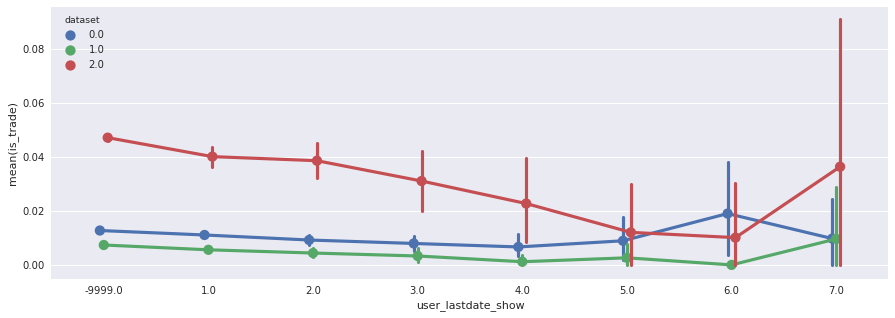

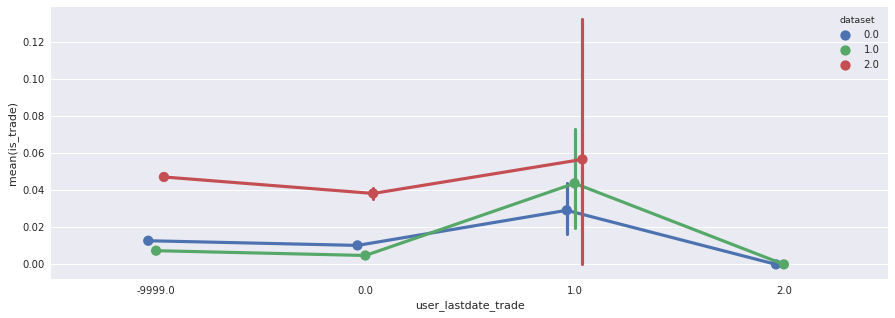

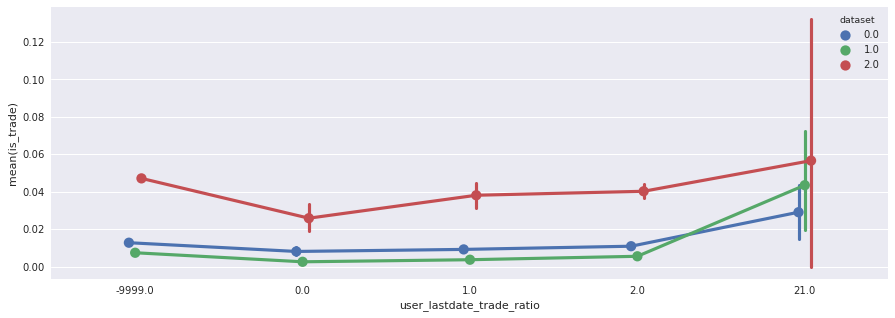

In [46]:
# 用户维度特征
temp = df.copy()
tempDf = statDateTrade(df, 'user_id')
tempDf.columns = ['user_his_show','user_his_trade']
tempDf['user_his_trade_ratio'] = biasSmooth(tempDf['user_his_trade'].values, tempDf['user_his_show'].values)
startDate = temp['date'].min()
# tempDf['user_his_show_perday'] = tempDf['user_his_show'] / (tempDf.index.get_level_values('date')-startDate).days
temp = temp.merge(tempDf, how='left', left_on=['user_id','date'], right_index=True)

tempDf = pd.pivot_table(temp, index=['user_id','context_timestamp'], values=['is_trade'], aggfunc=len)
tempDf.columns = ['show']
tempDf.reset_index(inplace=True)
tempDf['last_user_id'] = tempDf['user_id'].shift(1)
tempDf['last_user_id'] = tempDf['last_user_id']==tempDf['user_id']
tempDf['last_show_time'] = tempDf['context_timestamp'].shift(1)
tempDf.loc[~tempDf.last_user_id, 'last_show_time'] = np.nan
tempDf['user_last_show_timedelta'] = tempDf['context_timestamp'] - tempDf['last_show_time']
tempDf['user_last_show_timedelta'] = tempDf['user_last_show_timedelta'].dt.seconds
tempDf['user_last_show_timedelta'].fillna(999999, inplace=True)
# 穿越特征
tempDf['next_user_id'] = tempDf['user_id'].shift(-1)
tempDf['next_user_id'] = tempDf['next_user_id']==tempDf['user_id']
tempDf['next_show_time'] = tempDf['context_timestamp'].shift(-1)
tempDf.loc[~tempDf.next_user_id, 'next_show_time'] = np.nan
tempDf['user_next_show_timedelta'] = tempDf['next_show_time'] - tempDf['context_timestamp']
tempDf['user_next_show_timedelta'] = tempDf['user_next_show_timedelta'].dt.seconds
tempDf['user_next_show_timedelta'].fillna(999999, inplace=True)
tempDf['user_near_timedelta'] = tempDf['user_next_show_timedelta'] - tempDf['user_last_show_timedelta']
hourShowList = []
hourShowTemp = {}
for same, dt, show in tempDf[['last_user_id','context_timestamp','show']].values:
    if same:
        [hourShowTemp.pop(k) for k in list(hourShowTemp) if k<dt-timedelta(hours=1)]
        hourShowList.append(np.sum(list(hourShowTemp.values())))
        hourShowTemp[dt] = show
    else:
        hourShowList.append(0)
        hourShowTemp = {dt:show}
tempDf['user_lasthour_show'] = hourShowList
temp = temp.merge(tempDf[['user_id','context_timestamp','user_last_show_timedelta','user_next_show_timedelta','user_near_timedelta','user_lasthour_show']], how='left', on=['user_id','context_timestamp'])

tempDf = pd.pivot_table(temp, index=['user_id','date'], values=['is_trade'], aggfunc=[len,np.sum])
tempDf.columns = ['user_lastdate_show','user_lastdate_trade']
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
tempDf['user_lastdate_trade_ratio'] = biasSmooth(tempDf['user_lastdate_trade'].values, tempDf['user_lastdate_show'].values)
temp = temp.merge(tempDf, how='left', on=['user_id','date'])
# temp['user_lastdate_show'].fillna(0, inplace=True)
# temp.loc[temp.date=='2018-08-31', 'user_lastdate_show'] = np.nan

cols = ['user_his_trade_ratio','user_last_show_timedelta','user_next_show_timedelta','user_his_show','user_his_trade','user_lasthour_show','user_lastdate_show','user_lastdate_trade','user_lastdate_trade_ratio']
print(getFeaPearsonr(temp, cols))
temp['user_his_trade_ratio'] = temp['user_his_trade_ratio'] // 0.0005
temp.loc[temp.user_his_trade_ratio>30,'user_his_trade_ratio'] = 31
temp.loc[:,['user_last_show_timedelta','user_next_show_timedelta']] = temp.loc[:,['user_last_show_timedelta','user_next_show_timedelta']] // 100
temp.loc[temp.user_last_show_timedelta>30,'user_last_show_timedelta'] = 30
temp.loc[temp.user_next_show_timedelta>30,'user_next_show_timedelta'] = 30
temp.loc[temp.user_his_show>8,'user_his_show'] = 9
temp.loc[temp.user_lasthour_show>7,'user_lasthour_show'] = 8
temp.loc[temp.user_lastdate_show>7,'user_lastdate_show'] = 7
temp['user_lastdate_trade_ratio'] = temp['user_lastdate_trade_ratio'] // 0.0005
temp.loc[temp.user_lastdate_trade_ratio>20,'user_lastdate_trade_ratio'] = 21
printSingleFeaLine(temp, cols)

强特征：
+ 用户距离上次点击时长
+ 用户距离下次点击时长

弱相关：
+ 用户历史交易率
+ 用户过去一小时点击量
+ 用户前一天点击量

In [22]:
# 用户维度特征
def addUserFea(df):
    tempDf = statDateTrade(df, 'user_id')
    tempDf.columns = ['user_his_show','user_his_trade']
    tempDf['user_his_trade_ratio'] = biasSmooth(tempDf['user_his_trade'].values, tempDf['user_his_show'].values)
    startDate = df['date'].min()
    tempDf['user_his_show_perday'] = tempDf['user_his_show'] / (tempDf.index.get_level_values('date')-startDate).days
    df = df.merge(tempDf, how='left', left_on=['user_id','date'], right_index=True)

    tempDf = pd.pivot_table(df, index=['user_id','context_timestamp'], values=['is_trade'], aggfunc=len)
    tempDf.columns = ['show']
    tempDf.reset_index(inplace=True)
    tempDf['last_user_id'] = tempDf['user_id'].shift(1)
    tempDf['last_user_id'] = tempDf['last_user_id']==tempDf['user_id']
    tempDf['last_show_time'] = tempDf['context_timestamp'].shift(1)
    tempDf.loc[~tempDf.last_user_id, 'last_show_time'] = np.nan
    tempDf['user_last_show_timedelta'] = tempDf['context_timestamp'] - tempDf['last_show_time']
    tempDf['user_last_show_timedelta'] = tempDf['user_last_show_timedelta'].dt.seconds
    tempDf['user_last_show_timedelta'].fillna(999999, inplace=True)
    # 穿越特征
    tempDf['next_user_id'] = tempDf['user_id'].shift(-1)
    tempDf['next_user_id'] = tempDf['next_user_id']==tempDf['user_id']
    tempDf['next_show_time'] = tempDf['context_timestamp'].shift(-1)
    tempDf.loc[~tempDf.next_user_id, 'next_show_time'] = np.nan
    tempDf['user_next_show_timedelta'] = tempDf['next_show_time'] - tempDf['context_timestamp']
    tempDf['user_next_show_timedelta'] = tempDf['user_next_show_timedelta'].dt.seconds
    tempDf['user_next_show_timedelta'].fillna(999999, inplace=True)
    tempDf['user_near_timedelta'] = tempDf['user_next_show_timedelta'] - tempDf['user_last_show_timedelta']
    hourShowList = []
    hourShowTemp = {}
    for same, dt, show in tempDf[['last_user_id','context_timestamp','show']].values:
        if same:
            [hourShowTemp.pop(k) for k in list(hourShowTemp) if k<dt-timedelta(hours=1)]
            hourShowList.append(np.sum(list(hourShowTemp.values())))
            hourShowTemp[dt] = show
        else:
            hourShowList.append(0)
            hourShowTemp = {dt:show}
    tempDf['user_lasthour_show'] = hourShowList
    df = df.merge(tempDf[['user_id','context_timestamp','user_last_show_timedelta','user_next_show_timedelta','user_near_timedelta','user_lasthour_show']], how='left', on=['user_id','context_timestamp'])

    tempDf = pd.pivot_table(df, index=['user_id','date'], values=['is_trade'], aggfunc=len)
    tempDf.columns = ['user_lastdate_show']
    tempDf.reset_index(inplace=True)
    tempDf['date'] = tempDf['date'] + timedelta(days=1)
    df = df.merge(tempDf, how='left', on=['user_id','date'])
    df['user_lastdate_show'].fillna(0, inplace=True)
    df.loc[df.date=='2018-08-31', 'user_lastdate_show'] = np.nan
    return df

In [23]:
# 增加用户维度特征
df = addUserFea(df)

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                            pearsonr      p_values
cate_his_trade_ratio       0.0618783             0
cate_his_show              0.0209061  8.68276e-134
cate_age_delta             0.0164673   4.38817e-94
cate_price_mean           -0.0541329             0
cate_sales_mean            0.0544605             0
cate_lastdate_show         0.0222259  5.91312e-151
cate_lastdate_trade        0.0309483  8.63893e-291
cate_lastdate_trade_ratio  0.0391393             0
 1.0       600905
 2.0       254870
 4.0       180331
-9999.0    178800
 3.0       139588
 0.0       121127
 7.0        52009
 6.0        19807
 5.0        16829
 8.0          540
Name: cate_his_trade_ratio, dtype: int64
 2.0       201684
-9999.0    178800
 1.0       166192
 0.0       160832
 4.0       158463
 5.0       106419
 7.0       101996
 3.0       101086
 6.0        79846
 8.0        67718
 9.0        57380
 12.0       56302
 14.0       38742
 10.0       33793
 18.0       22641
 16.0       17814
 11.0       15098
Name: cate_his

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


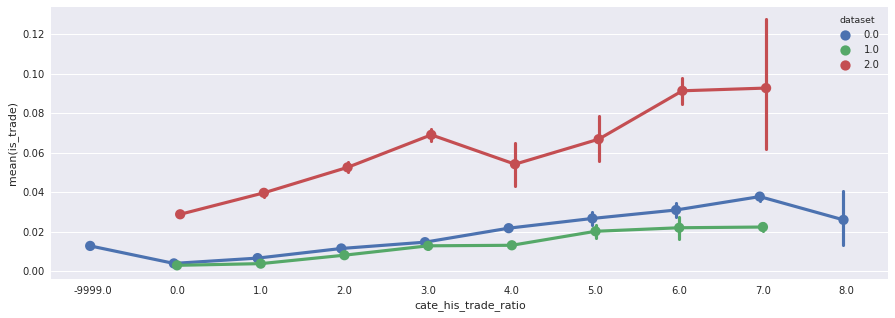

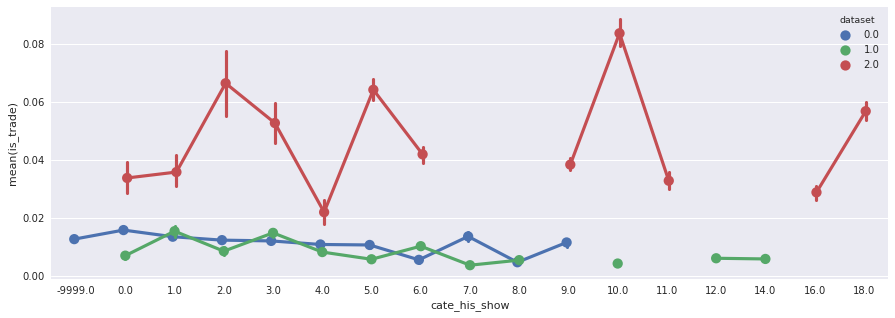

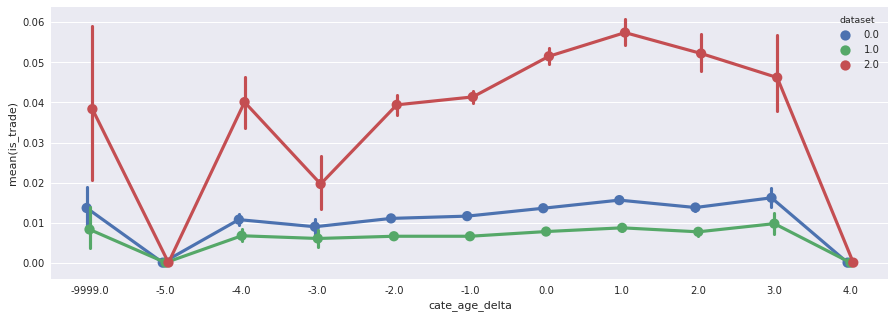

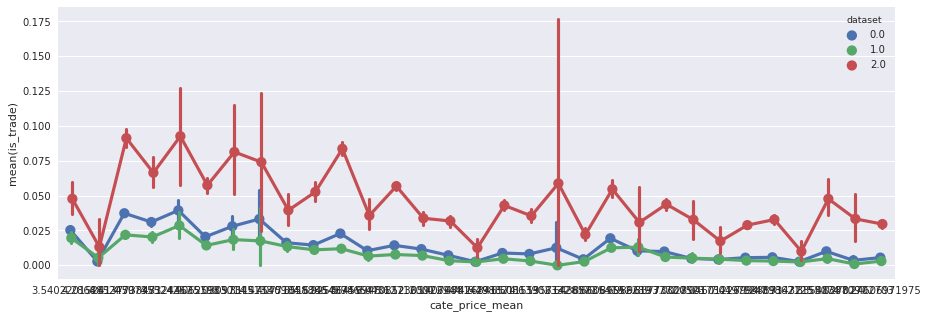

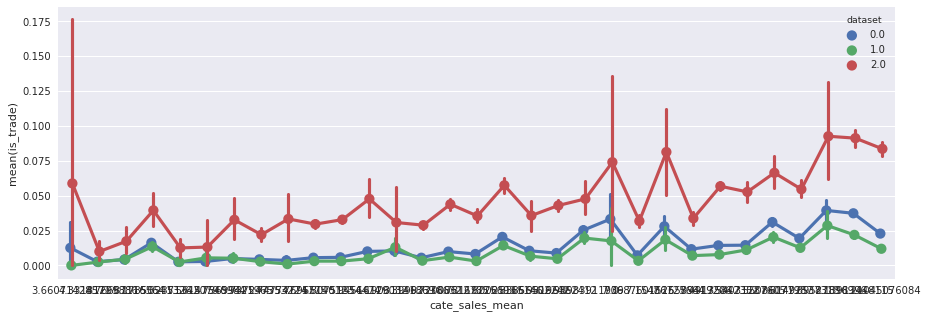

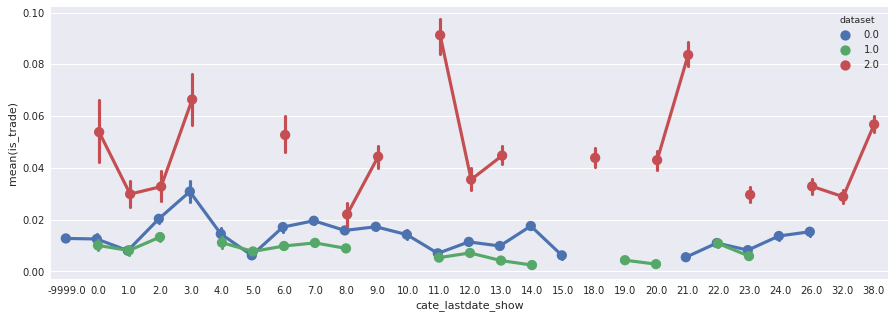

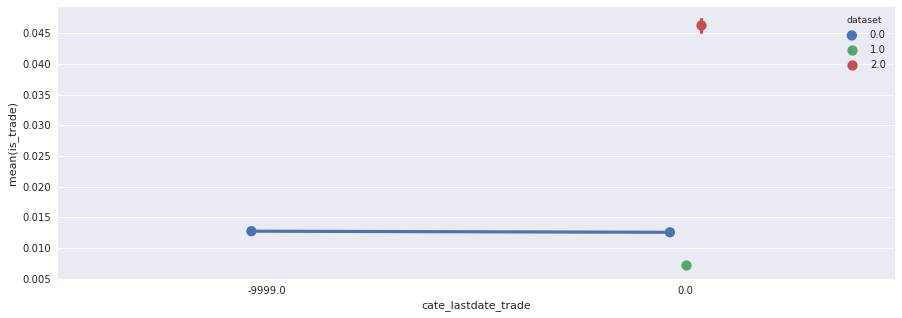

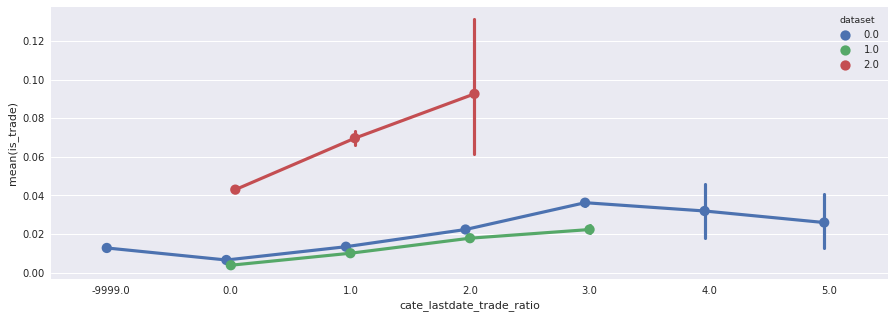

In [50]:
# 类别维度统计特征
temp = df.copy()
tempDf = statDateTrade(temp, 'item_category1')
tempDf.columns = ['cate_his_show','cate_his_trade']
tempDf['cate_his_trade_ratio'] = biasSmooth(tempDf['cate_his_trade'].values, tempDf['cate_his_show'].values)
startDate = temp['date'].min()
tempDf['cate_his_show_perday'] = tempDf['cate_his_show'] / (tempDf.index.get_level_values('date')-startDate).days
temp = temp.merge(tempDf, how='left', left_on=['item_category1','date'], right_index=True)

tempDf = pd.pivot_table(temp, index=['item_category1','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['cate_lastdate_show','cate_lastdate_trade']
tempDf['cate_lastdate_trade_ratio'] = biasSmooth(tempDf['cate_lastdate_trade'].values, tempDf['cate_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp = temp.merge(tempDf, how='left', on=['item_category1','date'])

temp = statItemFea(temp,'item_category1', 'cate')
temp = statUserAge(temp,'item_category1', 'cate')

tempDf = temp.copy()
cols = ['cate_his_trade_ratio','cate_his_show','cate_age_delta','cate_price_mean','cate_sales_mean','cate_lastdate_show','cate_lastdate_trade','cate_lastdate_trade_ratio']
print(getFeaPearsonr(tempDf, cols))
tempDf['cate_his_trade_ratio'] = tempDf['cate_his_trade_ratio'] // 0.005
tempDf['cate_his_show_perday'] = tempDf['cate_his_show_perday'] // 1000
tempDf['cate_his_show'] = tempDf['cate_his_show'] // 10000
tempDf['cate_age_delta'] = tempDf['cate_age_delta'] // 1
tempDf['cate_lastdate_show'] = tempDf['cate_lastdate_show'] // 5000
tempDf['cate_lastdate_trade'] = tempDf['cate_lastdate_trade'] // 50
tempDf['cate_lastdate_trade_ratio'] = tempDf['cate_lastdate_trade_ratio'] // 0.002
tempDf.loc[tempDf.cate_lastdate_trade_ratio>10,'cate_lastdate_trade_ratio'] = 11
printSingleFeaLine(tempDf, cols)

强相关：
+ 类别转化率

弱相关：
+ 年龄与类别平均年龄差值

                              pearsonr     p_values
cate_his_trade_ratio         0.0738516            0
cate_his_show               0.00499895  0.000228174
cate_age_delta                0.014589  3.11345e-30
cate_sales_mean              0.0618271            0
cate_lastdate_show         0.000438792     0.746315
cate_lastdate_trade          0.0257528  2.08169e-80
cate_lastdate_trade_ratio     0.052296            0
-9999.0    1021239
 1.0        198096
 3.0        121872
 0.0        102123
 4.0         52911
 5.0         27231
 2.0         19223
 6.0          6981
 8.0          4735
 10.0         4279
 7.0          2491
 9.0          2250
 11.0         1075
 14.0          102
 16.0           54
 17.0           46
 21.0           41
 15.0           38
 12.0           19
Name: cate_his_trade_ratio, dtype: int64
-9999.0    1021239
 0.0        169034
 1.0         77268
 2.0         69367
 3.0         66037
 5.0         56391
 4.0         42090
 7.0         20224
 8.0         19681
 6.0       

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


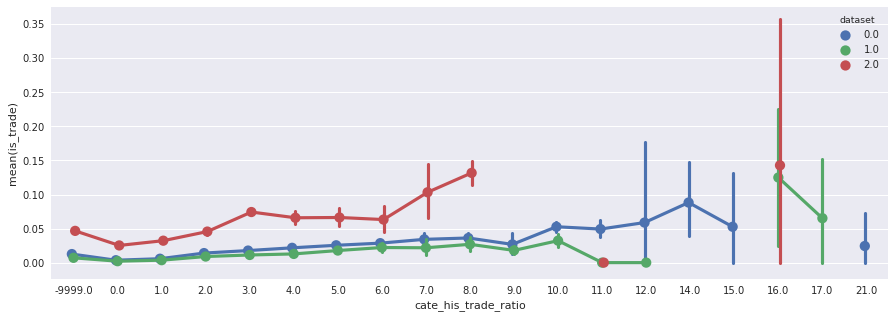

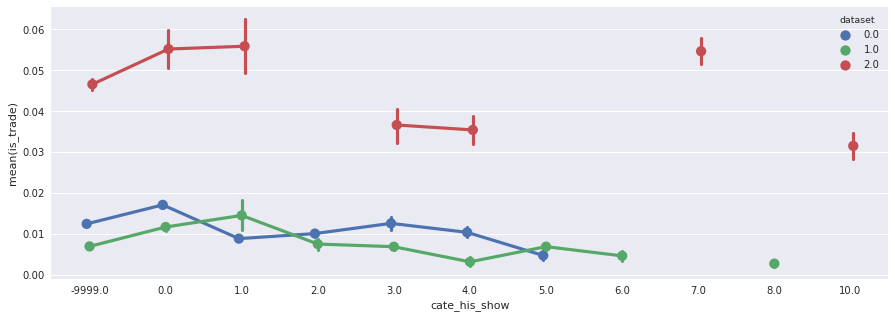

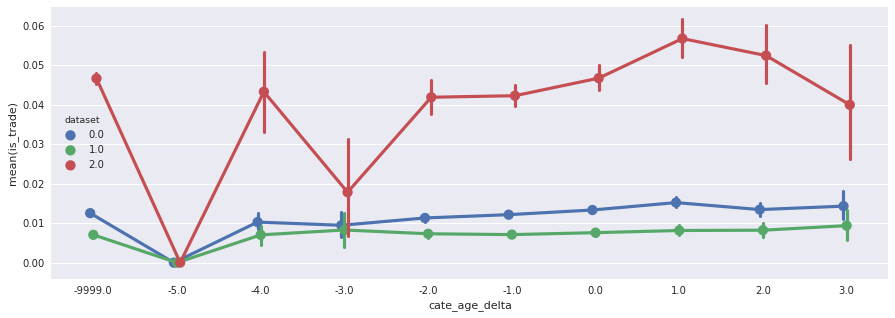

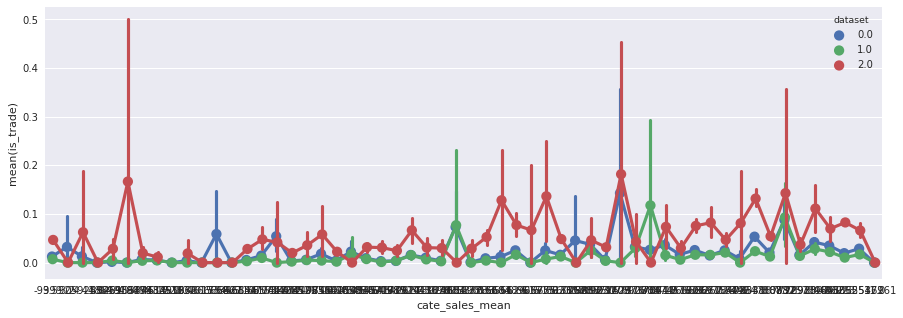

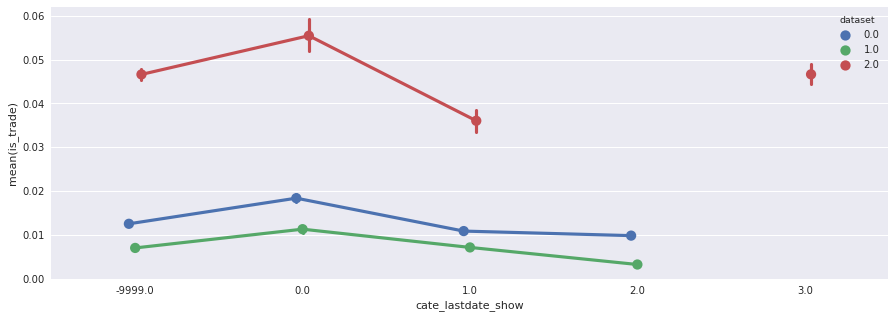

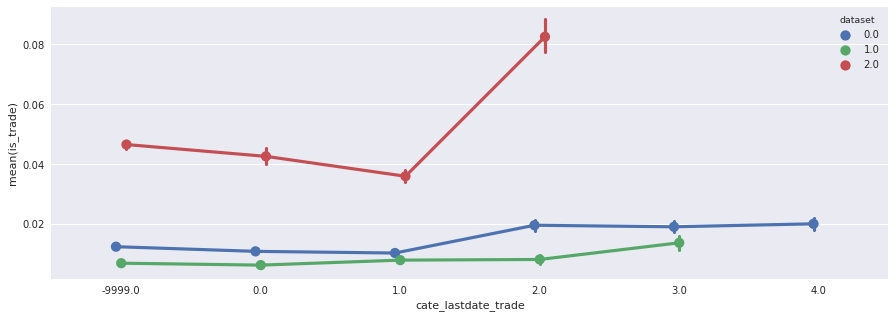

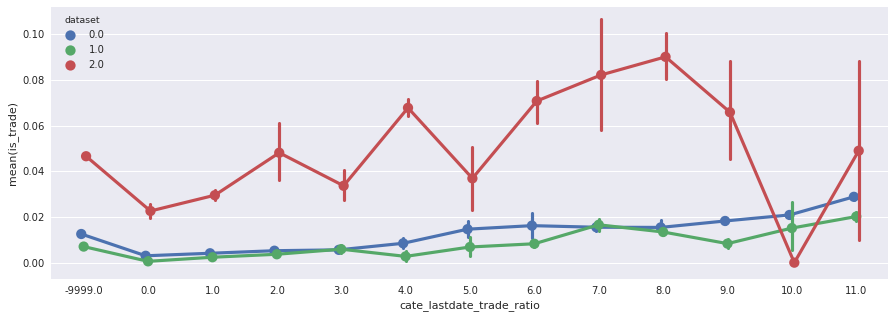

In [53]:
# 二级类别维度统计特征
temp = df.copy()
tempDf = statDateTrade(temp, 'item_category2')
tempDf.columns = ['cate_his_show','cate_his_trade']
tempDf['cate_his_trade_ratio'] = biasSmooth(tempDf['cate_his_trade'].values, tempDf['cate_his_show'].values)
startDate = temp['date'].min()
tempDf['cate_his_show_perday'] = tempDf['cate_his_show'] / (tempDf.index.get_level_values('date')-startDate).days
temp = temp.merge(tempDf, how='left', left_on=['item_category2','date'], right_index=True)

tempDf = pd.pivot_table(temp, index=['item_category2','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['cate_lastdate_show','cate_lastdate_trade']
tempDf['cate_lastdate_trade_ratio'] = biasSmooth(tempDf['cate_lastdate_trade'].values, tempDf['cate_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp = temp.merge(tempDf, how='left', on=['item_category2','date'])

temp = statItemFea(temp,'item_category2', 'cate')
temp = statUserAge(temp,'item_category2', 'cate')

tempDf = temp.copy()
cols = ['cate_his_trade_ratio','cate_his_show','cate_age_delta','cate_lastdate_show','cate_lastdate_trade','cate_lastdate_trade_ratio']
print(getFeaPearsonr(tempDf, cols))
tempDf['cate_his_trade_ratio'] = tempDf['cate_his_trade_ratio'] // 0.005
tempDf['cate_his_show'] = tempDf['cate_his_show'] // 10000
tempDf['cate_age_delta'] = tempDf['cate_age_delta'] // 1
tempDf['cate_lastdate_show'] = tempDf['cate_lastdate_show'] // 5000
tempDf['cate_lastdate_trade'] = tempDf['cate_lastdate_trade'] // 50
tempDf['cate_lastdate_trade_ratio'] = tempDf['cate_lastdate_trade_ratio'] // 0.002
tempDf.loc[tempDf.cate_lastdate_trade_ratio>10,'cate_lastdate_trade_ratio'] = 11
printSingleFeaLine(tempDf, cols)

二级类目只有类别历史转化率能用

In [54]:
# 类别维度统计特征
def addCateFea(df):
    tempDf = statDateTrade(df, 'item_category1')
    tempDf.columns = ['cate_his_show','cate_his_trade']
    tempDf['cate_his_trade_ratio'] = biasSmooth(tempDf['cate_his_trade'].values, tempDf['cate_his_show'].values)
    startDate = df['date'].min()
    tempDf['cate_his_show_perday'] = tempDf['cate_his_show'] / (tempDf.index.get_level_values('date')-startDate).days
    df = df.merge(tempDf, how='left', left_on=['item_category1','date'], right_index=True)

    tempDf = pd.pivot_table(df, index=['item_category1','date'], values='is_trade', aggfunc=[len,np.sum])
    tempDf.columns = ['cate_lastdate_show','cate_lastdate_trade']
    tempDf['cate_lastdate_trade_ratio'] = biasSmooth(tempDf['cate_lastdate_trade'].values, tempDf['cate_lastdate_show'].values)
    tempDf.reset_index(inplace=True)
    tempDf['date'] = tempDf['date'] + timedelta(days=1)
    df = df.merge(tempDf, how='left', on=['item_category1','date'])

    df = statItemFea(df,'item_category1', 'cate')
    df = statUserAge(df,'item_category1', 'cate')
    return df

In [55]:
# 增加类别维度特征
df = addCateFea(df)

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                         pearsonr      p_values
item_his_trade_ratio    0.0453849             0
item_his_show_ratio    0.00125469     0.0699313
item_prop_num           0.0443737             0
item_his_show_perday    0.0222339  1.08833e-218
item_his_trade_perday   0.0564448             0
item_his_show           0.0388741             0
item_his_trade          0.0691759             0
item_his_show_delta     0.0188201  2.88664e-157
item_age_delta           0.012643   1.48115e-80
item_age_mean            0.014947  4.43725e-112
item_age_std            0.0119504   6.86026e-72
item_sales_delta        0.0620524             0
item_collected_delta    0.0194094  1.25012e-187
item_price_delta       -0.0100216   2.08315e-51
item_pv_delta           0.0106414   9.83411e-58
 0.0       1270886
 2.0        192030
 1.0        190845
-9999.0     178713
 3.0         88540
 4.0         70215
 5.0         51334
 6.0         39291
 7.0         35093
 8.0         24849
 9.0         22541
 21.0        20021
 11.

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


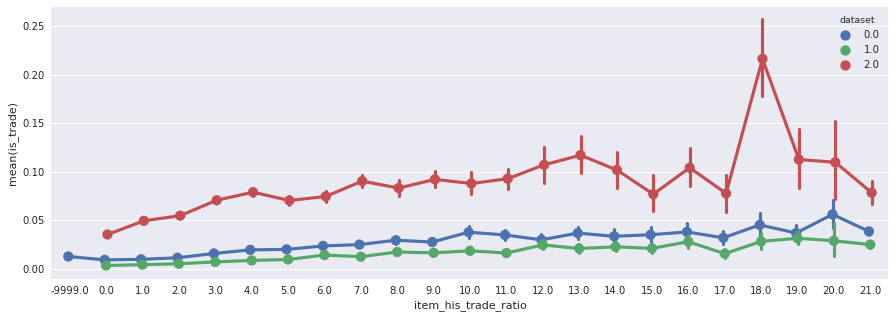

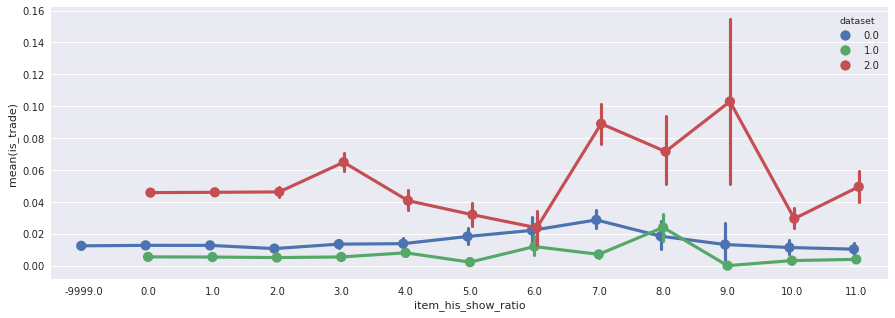

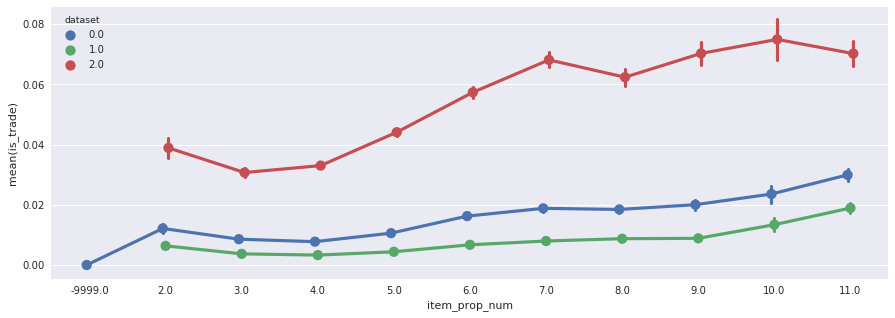

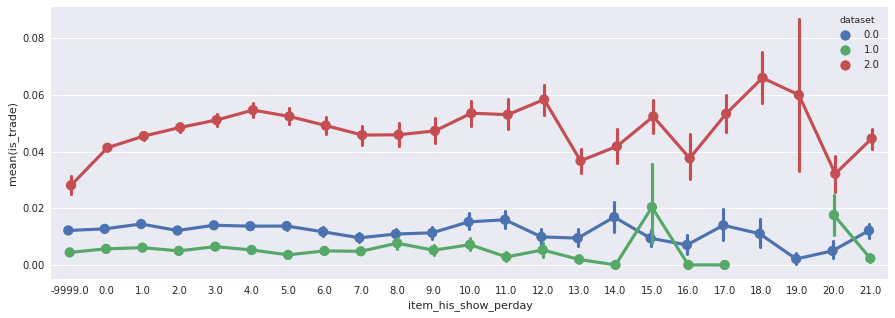

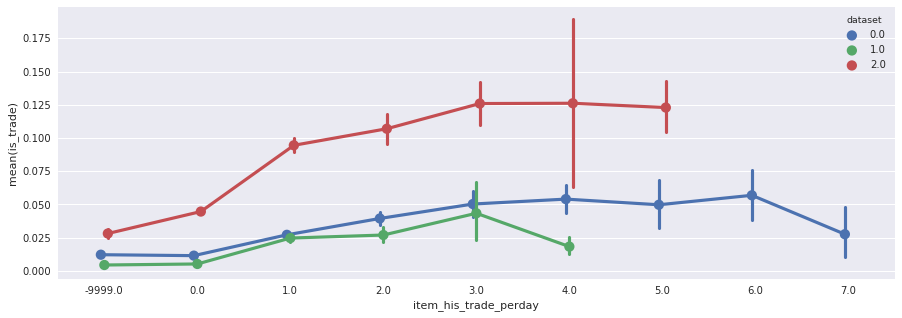

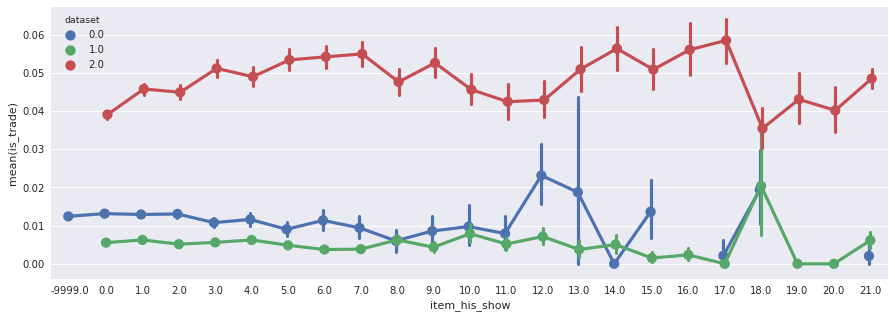

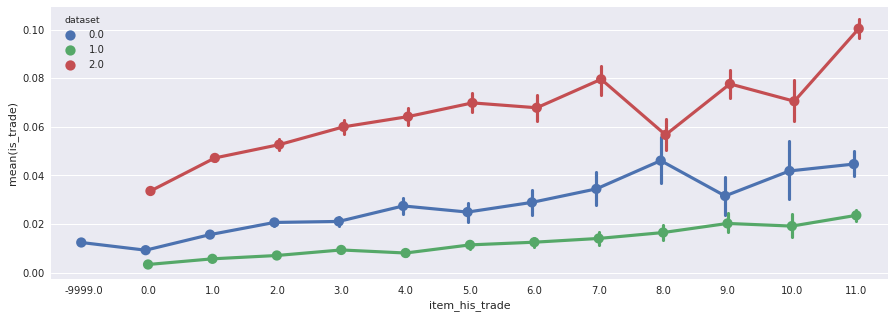

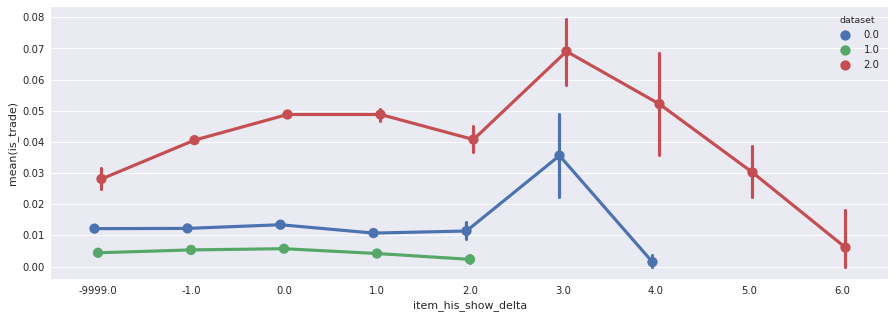

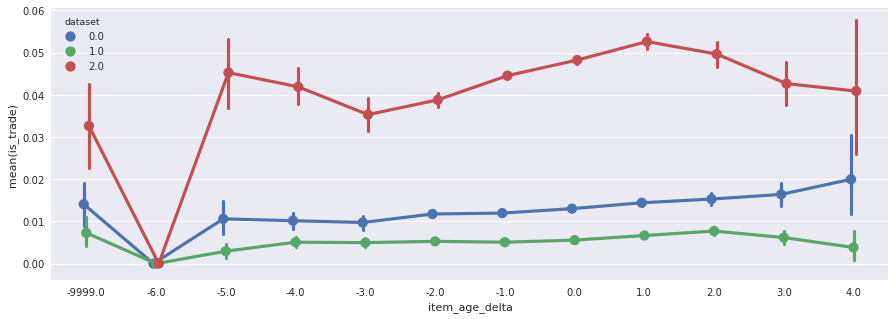

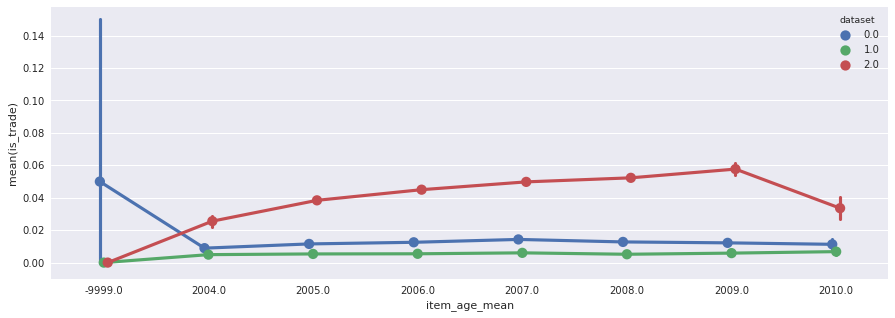

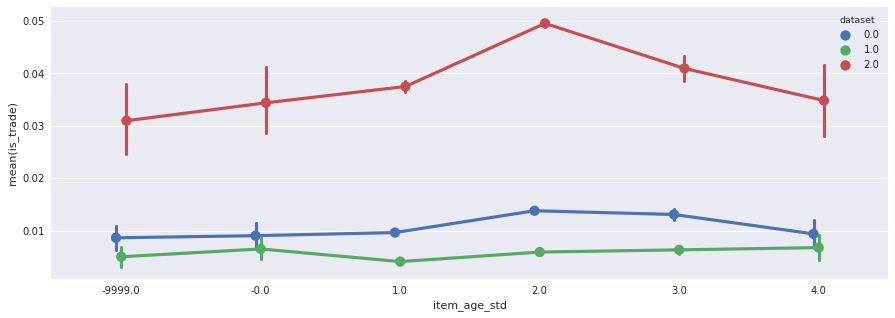

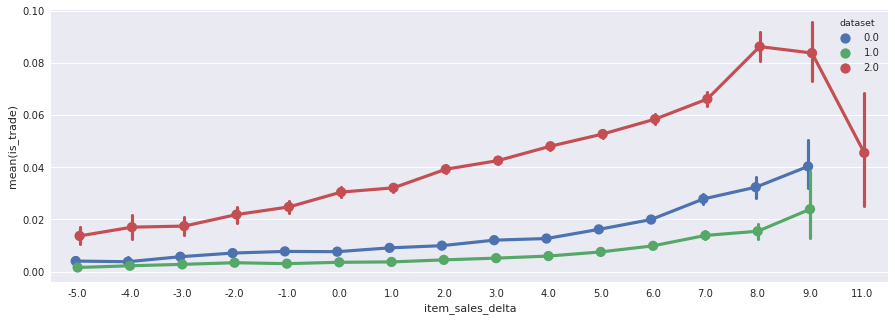

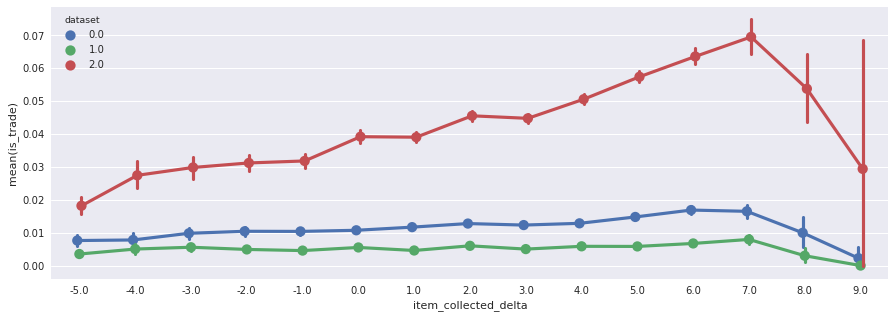

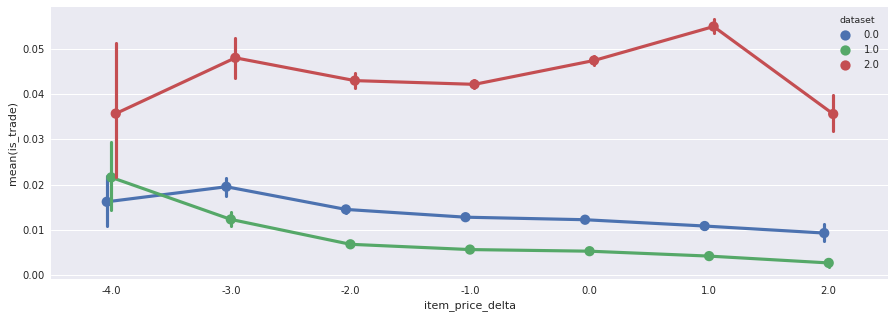

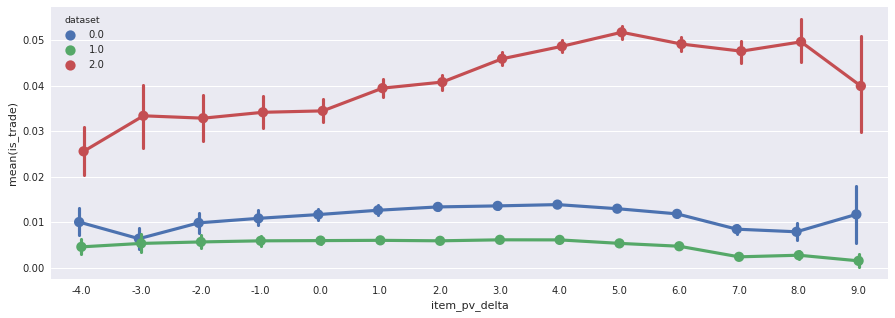

In [26]:
# 研究商品统计特征
temp = df.copy()
tempDf = statDateTrade(temp, 'item_id')
tempDf.columns = ['item_his_show','item_his_trade']
tempDf['item_his_trade_ratio'] = biasSmooth(tempDf['item_his_trade'].values, tempDf['item_his_show'].values)
temp = temp.merge(tempDf, how='left', left_on=['item_id','date'], right_index=True)
temp['item_his_show_ratio'] = biasSmooth(temp.item_his_show.values, temp.cate_his_show.values)
temp['item_prop_num'] = temp['item_property_list'].dropna().map(lambda x: len(x))

tempDf = pd.pivot_table(temp, index=['item_id','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['item_lastdate_show','item_lastdate_trade']
tempDf['item_lastdate_trade_ratio'] = biasSmooth(tempDf['item_lastdate_trade'].values, tempDf['item_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp = temp.merge(tempDf, how='left', on=['item_id','date'])

temp['item_sales_delta'] = temp['item_sales_level'] - temp['cate_sales_mean']
temp['item_collected_delta'] = temp['item_collected_level'] - temp['cate_collected_mean']
temp['item_price_delta'] = temp['item_price_level'] - temp['cate_price_mean']
temp['item_pv_delta'] = temp['item_pv_level'] - temp['cate_pv_mean']
tempDf = pd.pivot_table(temp.drop_duplicates(['item_id','date']), index=['item_category1','date'], values=['item_his_show_perday'], aggfunc=np.mean)
tempDf.columns = ['item_his_show_mean']
temp = temp.merge(tempDf, how='left', left_on=['item_category1','date'], right_index=True)
temp['item_his_show_delta'] = temp['item_his_show_perday'] - temp['item_his_show_mean']

temp = statUserAge(temp, 'item_id', 'item')
temp = statUserGender(temp, 'item_id', 'item')

cols = ['item_his_trade_ratio','item_his_show_ratio','item_prop_num','item_his_show_perday','item_his_trade_perday','item_his_show','item_his_trade','item_his_show_delta']
cols = cols+['item_age_delta','item_age_mean','item_age_std',]
cols = cols+['item_sales_delta','item_collected_delta','item_price_delta','item_pv_delta']
print(getFeaPearsonr(temp, cols))
temp['item_his_trade_ratio'] = temp['item_his_trade_ratio'] // 0.005
temp.loc[temp.item_his_trade_ratio>20,'item_his_trade_ratio'] = 21
temp['item_his_show_ratio'] = temp['item_his_show_ratio'] // 0.005
temp.loc[temp.item_his_show_ratio>10,'item_his_show_ratio'] = 11
temp['item_prop_num'] = temp['item_prop_num'] // 5
temp.loc[temp.item_prop_num<3,'item_prop_num'] = 2
temp.loc[temp.item_prop_num>10,'item_prop_num'] = 11
temp['item_his_show_perday'] = temp['item_his_show_perday'] // 10
temp.loc[temp.item_his_show_perday>20,'item_his_show_perday'] = 21
# temp['item_his_trade_perday'] = temp['item_his_trade_perday'] // 2
temp.loc[temp.item_his_trade_perday>6,'item_his_trade_perday'] = 7
temp['item_his_show'] = temp['item_his_show'] // 50
temp.loc[temp.item_his_show>20,'item_his_show'] = 21
temp.loc[temp.item_his_trade>10,'item_his_trade'] = 11
temp['item_his_show_delta'] = temp['item_his_show_delta'] // 100
temp['item_age_delta'] = temp['item_age_delta'] // 1
temp['item_age_mean'] = temp['item_age_mean'] // 0.5
temp.loc[temp.item_age_mean<2004,'item_age_mean'] = 2004
temp.loc[temp.item_age_mean>2010,'item_age_mean'] = 2010
temp['item_age_std'] = temp['item_age_std'] // 0.5
temp.loc[temp.item_age_std>4,'item_age_std'] = 4
temp['item_sales_delta'] = temp['item_sales_delta'] // 1
temp.loc[temp.item_sales_delta<-5,'item_sales_delta'] = -5
temp['item_collected_delta'] = temp['item_collected_delta'] // 1
temp.loc[temp.item_collected_delta<-5,'item_collected_delta'] = -5
temp['item_price_delta'] = temp['item_price_delta'] // 1
temp.loc[temp.item_price_delta<-4,'item_price_delta'] = -4
temp.loc[temp.item_price_delta>2,'item_price_delta'] = 2
temp['item_pv_delta'] = temp['item_pv_delta'] // 1
temp.loc[temp.item_pv_delta<-3,'item_pv_delta'] = -4
printSingleFeaLine(temp, cols)

In [61]:
# 研究商品统计特征
temp = df.copy()
tempDf = statDateTrade(temp, 'item_id')
tempDf.columns = ['item_his_show','item_his_trade']
tempDf['item_his_trade_ratio'] = biasSmooth(tempDf['item_his_trade'].values, tempDf['item_his_show'].values)
temp = temp.merge(tempDf, how='left', left_on=['item_id','date'], right_index=True)
temp['item_his_show_ratio'] = biasSmooth(temp.item_his_show.values, temp.cate_his_show.values)
temp['item_prop_num'] = temp['item_property_list'].dropna().map(lambda x: len(x))

tempDf = pd.pivot_table(temp, index=['item_id','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['item_lastdate_show','item_lastdate_trade']
tempDf['item_lastdate_trade_ratio'] = biasSmooth(tempDf['item_lastdate_trade'].values, tempDf['item_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp = temp.merge(tempDf, how='left', on=['item_id','date'])

temp['item_sales_delta'] = temp['item_sales_level'] - temp['cate_sales_mean']
temp['item_collected_delta'] = temp['item_collected_level'] - temp['cate_collected_mean']
temp['item_price_delta'] = temp['item_price_level'] - temp['cate_price_mean']
temp['item_pv_delta'] = temp['item_pv_level'] - temp['cate_pv_mean']
tempDf = pd.pivot_table(temp.drop_duplicates(['item_id','date']), index=['item_category1','date'], values=['item_lastdate_show'], aggfunc=np.mean)
tempDf.columns = ['item_lastdate_show_mean']
temp = temp.merge(tempDf, how='left', left_on=['item_category1','date'], right_index=True)
temp['item_lastdate_show_delta'] = temp['item_lastdate_show'] - temp['item_lastdate_show_mean']

temp = statUserAge(temp, 'item_id', 'item')
temp = statUserGender(temp, 'item_id', 'item')


/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


                              pearsonr     p_values
item_his_trade_ratio         0.0628582            0
item_his_show_ratio        0.000181213     0.831062
item_prop_num                0.0448383            0
item_his_show               0.00963021  8.52833e-30
item_his_trade               0.0565176            0
item_lastdate_show          0.00731932   7.6894e-17
item_lastdate_trade          0.0434014            0
item_lastdate_trade_ratio    0.0414188            0
item_lastdate_show_delta    0.00497374  1.47441e-08
item_sales_delta             0.0524582            0
item_collected_delta         0.0148596  3.92848e-77
item_price_delta            -0.0172476  2.9583e-103
item_pv_delta               0.00496391  5.31535e-10
 0.0       827783
-9999.0    178800
 1.0       128125
 2.0       121285
 3.0        56638
 4.0        44219
 5.0        38597
 6.0        28607
 7.0        26028
 8.0        22279
 21.0       16339
 9.0        16005
 10.0       11810
 11.0       10477
 12.0        9273
 1

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


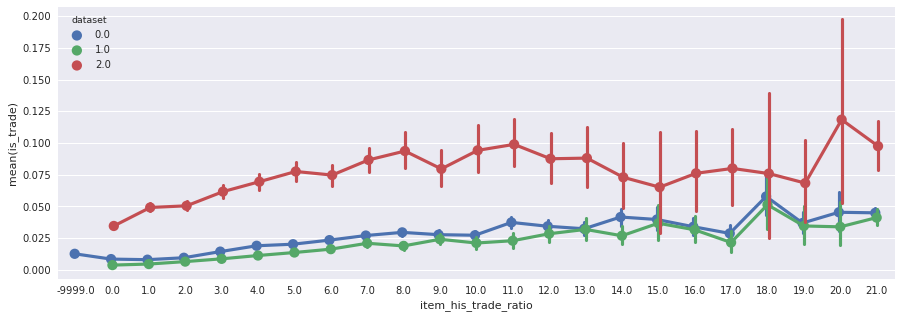

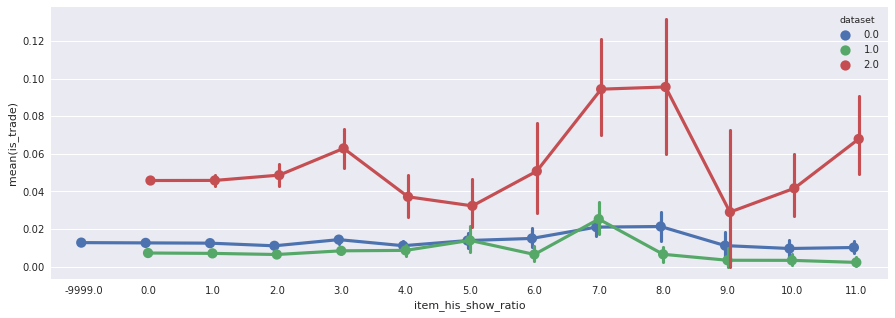

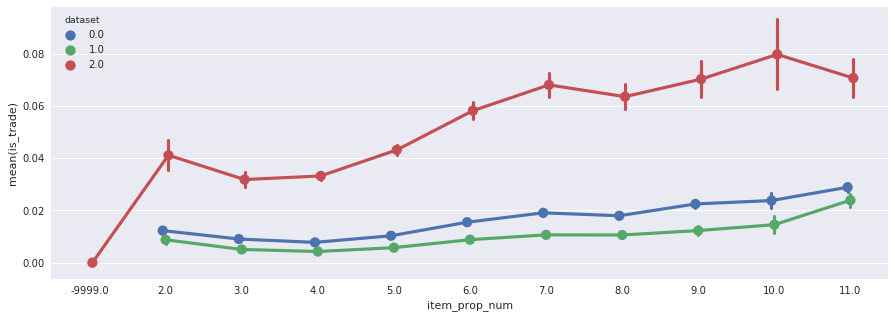

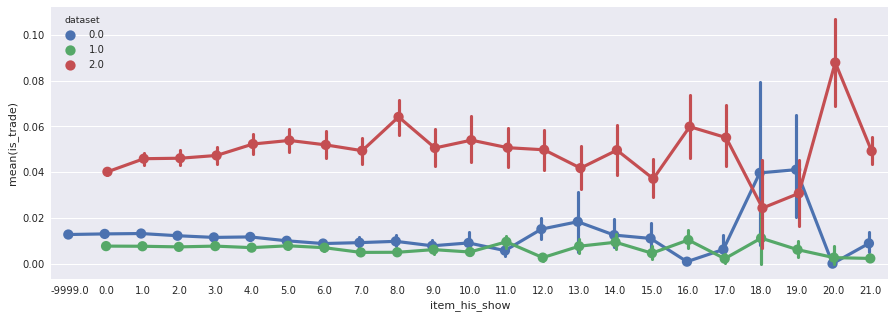

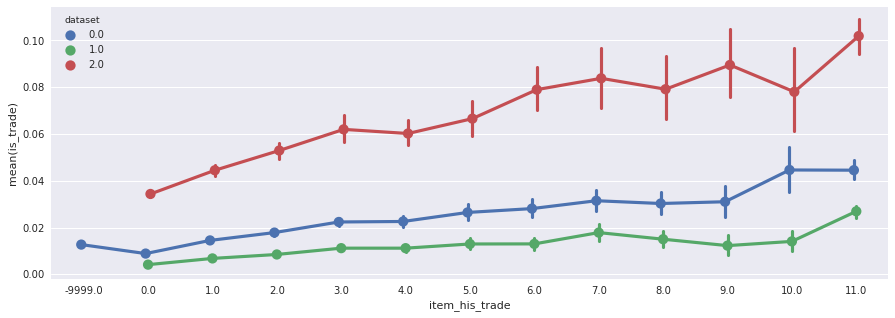

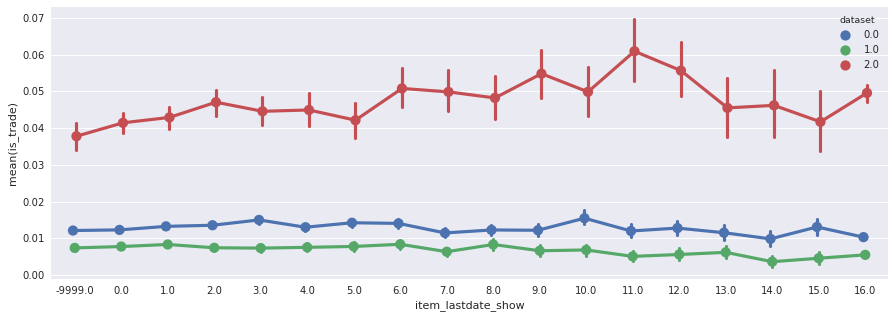

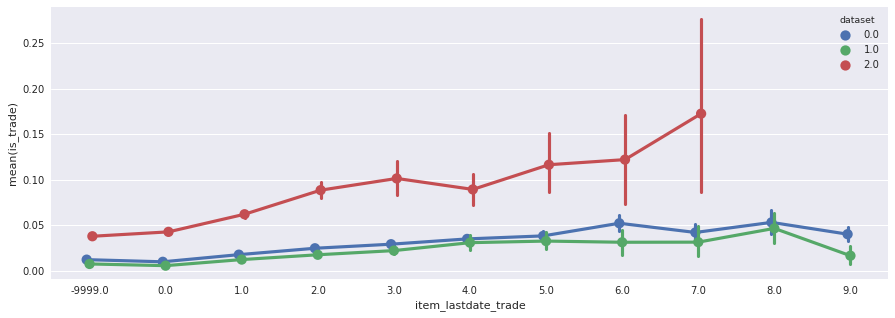

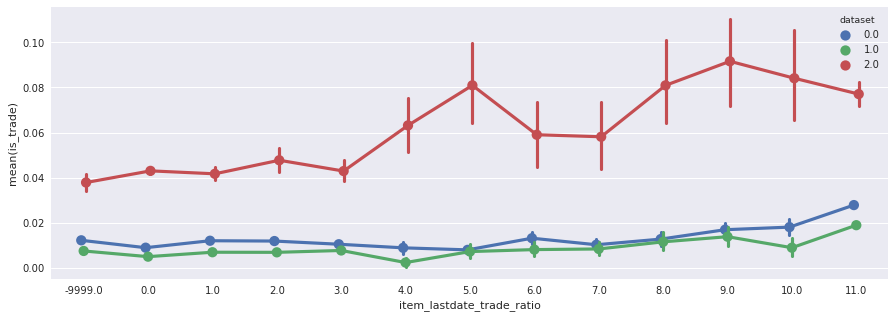

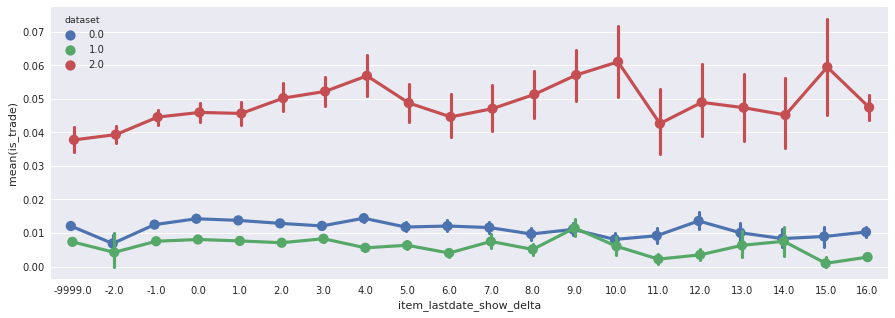

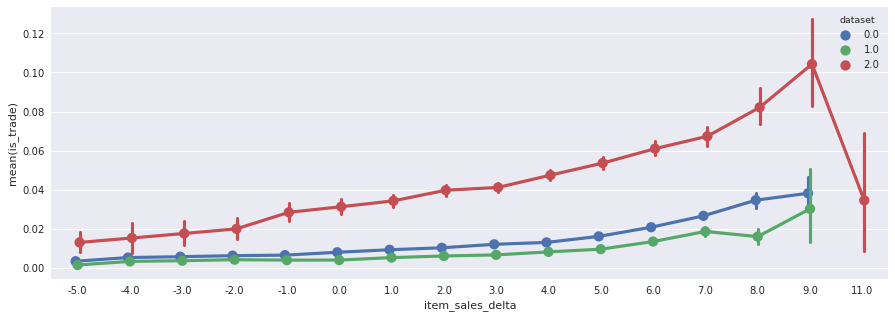

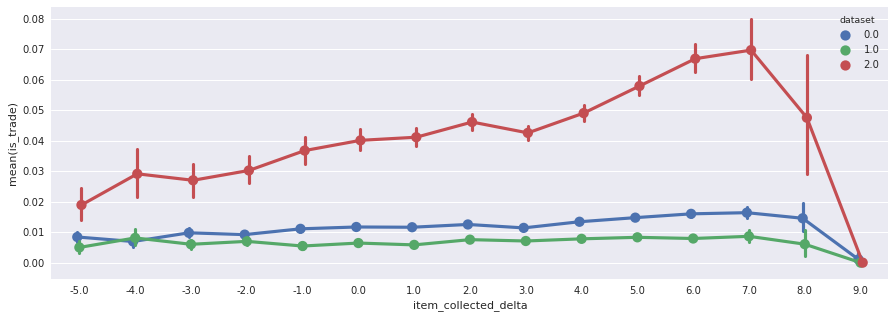

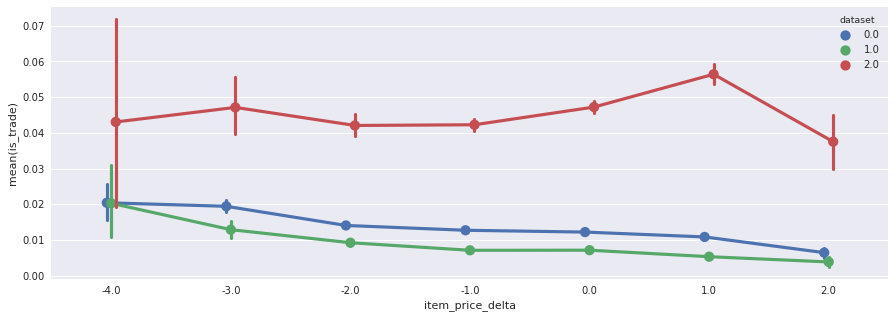

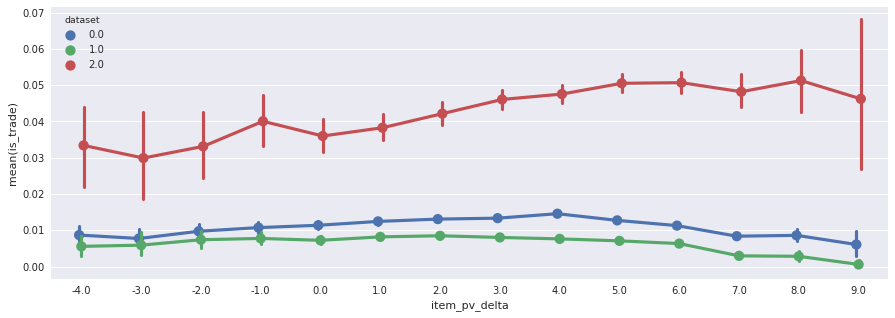

In [65]:

tempDf = temp.copy()
cols = ['item_his_trade_ratio','item_his_show_ratio','item_prop_num','item_his_show','item_his_trade','item_lastdate_show','item_lastdate_trade','item_lastdate_trade_ratio','item_lastdate_show_delta']
cols = cols+['item_sales_delta','item_collected_delta','item_price_delta','item_pv_delta']
print(getFeaPearsonr(tempDf, cols))
tempDf['item_his_trade_ratio'] = tempDf['item_his_trade_ratio'] // 0.005
tempDf.loc[tempDf.item_his_trade_ratio>20,'item_his_trade_ratio'] = 21
tempDf['item_his_show_ratio'] = tempDf['item_his_show_ratio'] // 0.005
tempDf.loc[tempDf.item_his_show_ratio>10,'item_his_show_ratio'] = 11
tempDf['item_prop_num'] = tempDf['item_prop_num'] // 5
tempDf.loc[tempDf.item_prop_num<3,'item_prop_num'] = 2
tempDf.loc[tempDf.item_prop_num>10,'item_prop_num'] = 11
tempDf['item_his_show'] = tempDf['item_his_show'] // 50
tempDf.loc[tempDf.item_his_show>20,'item_his_show'] = 21
tempDf.loc[tempDf.item_his_trade>10,'item_his_trade'] = 11
tempDf['item_lastdate_show'] = tempDf['item_lastdate_show'] // 5
tempDf.loc[tempDf.item_lastdate_show>15,'item_lastdate_show'] = 16
tempDf.loc[tempDf.item_lastdate_trade>8,'item_lastdate_trade'] = 9
tempDf['item_lastdate_trade_ratio'] = tempDf['item_lastdate_trade_ratio'] // 0.002
tempDf.loc[tempDf.item_lastdate_trade_ratio>10,'item_lastdate_trade_ratio'] = 11
tempDf.loc[tempDf.item_his_trade>10,'item_his_trade'] = 11
tempDf['item_lastdate_show_delta'] = tempDf['item_lastdate_show_delta'] // 10
tempDf.loc[tempDf.item_lastdate_show_delta>15, 'item_lastdate_show_delta'] = 16
tempDf['item_sales_delta'] = tempDf['item_sales_delta'] // 1
tempDf.loc[tempDf.item_sales_delta<-5,'item_sales_delta'] = -5
tempDf['item_collected_delta'] = tempDf['item_collected_delta'] // 1
tempDf.loc[tempDf.item_collected_delta<-5,'item_collected_delta'] = -5
tempDf['item_price_delta'] = tempDf['item_price_delta'] // 1
tempDf.loc[tempDf.item_price_delta<-4,'item_price_delta'] = -4
tempDf.loc[tempDf.item_price_delta>2,'item_price_delta'] = 2
tempDf['item_pv_delta'] = tempDf['item_pv_delta'] // 1
tempDf.loc[tempDf.item_pv_delta<-3,'item_pv_delta'] = -4
printSingleFeaLine(tempDf, cols)

强特征：
+ 商品历史转化率
+ 商品属性个数
+ 商品日交易量
+ 商品历史交易量
+ 商品销量与同类均值之差


                            pearsonr      p_values
item_lastdate_show         0.0360592    8.803e-304
item_lastdate_trade        0.0688141             0
item_lastdate_trade_ratio  0.0285253  7.47928e-191
-9999.0    1198459
 16.0       347874
 0.0        116474
 1.0        106613
 2.0         81119
 3.0         64147
 4.0         53447
 5.0         44603
 6.0         39549
 7.0         34761
 8.0         30429
 9.0         28072
 10.0        24515
 11.0        22913
 12.0        21597
 13.0        18144
 14.0        16426
 15.0        16050
Name: item_lastdate_show, dtype: int64
-9999.0    1198459
 0.0        780580
 1.0        154733
 2.0         54113
 3.0         24129
 4.0         16334
 9.0         11760
 5.0          9036
 6.0          7504
 8.0          4639
 7.0          3905
Name: item_lastdate_trade, dtype: int64
-9999.0    1198459
 0.0        592656
 1.0        121676
 4.0         50405
 3.0         48747
 2.0         48239
 36.0        29511
 6.0         14647
 5.0         1

/home/lab-zhao.yinhu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


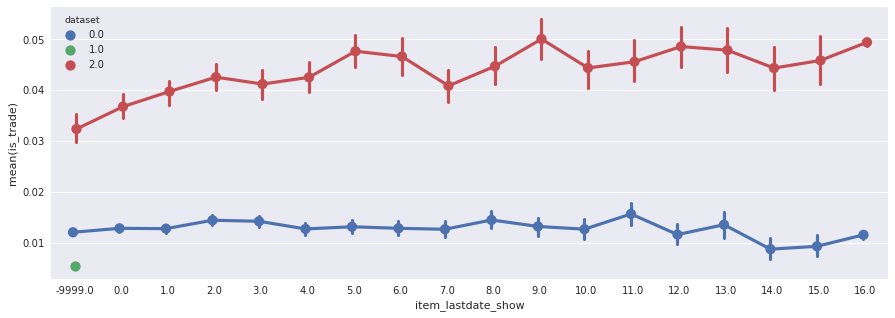

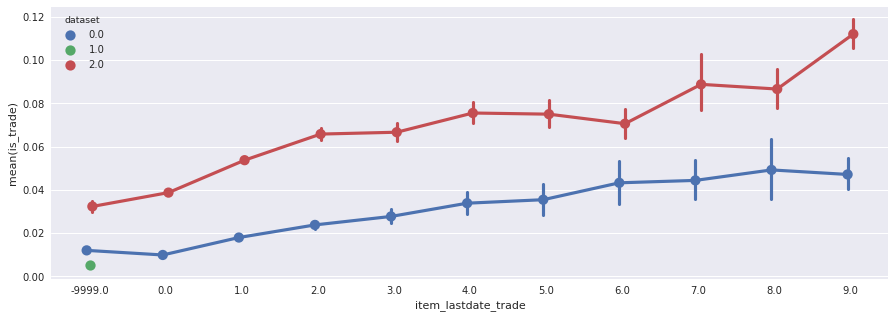

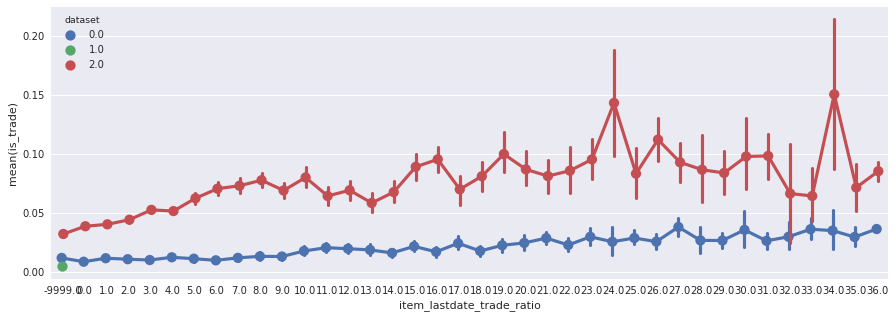

In [42]:
tempDf = pd.pivot_table(temp, index=['item_id','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['item_lastdate_show','item_lastdate_trade']
tempDf['item_lastdate_trade_ratio'] = biasSmooth(tempDf['item_lastdate_trade'].values, tempDf['item_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp.drop(['item_lastdate_show','item_lastdate_trade','item_lastdate_trade_ratio'], axis=1, inplace=True)
temp = temp.merge(tempDf, how='left', on=['item_id','date'])

cols = ['item_lastdate_show','item_lastdate_trade','item_lastdate_trade_ratio']
print(getFeaPearsonr(temp, cols))
temp['item_lastdate_show'] = temp['item_lastdate_show'] // 5
temp.loc[temp.item_lastdate_show>15,'item_lastdate_show'] = 16
temp.loc[temp.item_lastdate_trade>8,'item_lastdate_trade'] = 9
temp['item_lastdate_trade_ratio'] = temp['item_lastdate_trade_ratio'] // 0.002
temp.loc[temp.item_lastdate_trade_ratio>10,'item_lastdate_trade_ratio'] = 11
printSingleFeaLine(temp, ['item_lastdate_show','item_lastdate_trade','item_lastdate_trade_ratio'])

In [ ]:
# 研究店铺维度特征
temp = df.copy()
tempDf = statDateTrade(temp, 'shop_id')
tempDf.columns = ['shop_his_show','shop_his_trade']
tempDf['shop_his_trade_ratio'] = biasSmooth(tempDf['shop_his_trade'].values, tempDf['shop_his_show'].values)
temp = temp.merge(tempDf, how='left', left_on=['shop_id','date'], right_index=True)
temp['shop_his_show_ratio'] = biasSmooth(temp.shop_his_show.values, temp.cate_his_show.values)

tempDf = pd.pivot_table(temp, index=['shop_id'], values='date', aggfunc=np.min)
tempDf.columns = ['shop_startdate']
temp = temp.merge(tempDf, how='left', left_on=['shop_id'], right_index=True)
temp['shop_his_show_perday'] = temp['shop_his_show'] / (temp['date'] - temp['shop_startdate']).dt.days
temp['shop_his_trade_perday'] = temp['shop_his_trade'] / (temp['date'] - temp['shop_startdate']).dt.days

temp = statItemFea(temp, 'shop_id', 'shop')
temp['shop_sales_delta'] = temp['shop_sales_mean'] - temp['cate_sales_mean']
temp['shop_collected_delta'] = temp['shop_collected_mean'] - temp['cate_collected_mean']
temp['shop_price_delta'] = temp['shop_price_mean'] - temp['cate_price_mean']
temp['shop_pv_delta'] = temp['shop_pv_mean'] - temp['cate_pv_mean']

tempDf = pd.pivot_table(temp.drop_duplicates(['shop_id','date']), index=['item_category1','date'], values=['shop_his_show_perday','shop_his_trade_perday'], aggfunc=np.mean)
tempDf.columns = ['shop_his_show_mean','shop_his_trade_mean']
temp = temp.merge(tempDf, how='left', left_on=['item_category1','date'], right_index=True)
tempDf = pd.pivot_table(temp, index=['shop_id','date'], values='is_trade', aggfunc=[len,np.sum])
tempDf.columns = ['shop_lastdate_show','shop_lastdate_trade']
tempDf['shop_lastdate_trade_ratio'] = biasSmooth(tempDf['shop_lastdate_trade'].values, tempDf['shop_lastdate_show'].values)
tempDf.reset_index(inplace=True)
tempDf['date'] = tempDf['date'] + timedelta(days=1)
temp = temp.merge(tempDf, how='left', on=['shop_id','date'])
temp['shop_lastdate_show_delta'] = temp['shop_his_show_perday'] - temp['shop_his_show_mean']
temp['shop_lastdate_trade_delta'] = temp['shop_his_trade_perday'] - temp['shop_his_trade_mean']

temp['shop_his_show_delta'] = temp['shop_his_show_perday'] - temp['shop_his_show_mean']
temp['shop_his_trade_delta'] = temp['shop_his_trade_perday'] - temp['shop_his_trade_mean']

temp = statUserAge(temp,'shop_id', 'shop')
temp = statUserGender(temp,'shop_id', 'shop')

# cols = ['shop_his_trade_perday','shop_his_trade_ratio','shop_his_show_ratio','shop_his_trade','shop_his_trade_delta']
# cols = ['shop_age_delta','shop_age_std','shop_age_mean','shop_gender_ratio_delta','shop_gender_ratio']
cols = ['shop_collected_mean','shop_collected_sum','shop_price_mean','shop_price_sum','shop_pv_mean','shop_pv_sum','shop_sales_mean','shop_sales_sum','shop_item_count']
# cols = ['shop_sales_delta','shop_collected_delta','shop_price_delta','shop_pv_delta']
# cols = ['shop_score_service_delta','shop_score_delivery_delta','shop_score_description_delta','shop_review_positive_delta','shop_review_num_delta','shop_star_level_delta','shop_item_count_delta']
temp['shop_his_trade_ratio'] = temp['shop_his_trade_ratio'] // 0.005
temp.loc[temp.shop_his_trade_ratio>16,'shop_his_trade_ratio'] = 17
temp['shop_his_show_ratio'] = temp['shop_his_show_ratio'] // 0.005
temp.loc[temp.shop_his_show_ratio>10,'shop_his_show_ratio'] = 11
temp['shop_his_trade_perday'] = temp['shop_his_trade_perday'] // 2
temp.loc[temp.shop_his_trade_perday>6,'shop_his_trade_perday'] = 7
temp['shop_his_trade'] = temp['shop_his_trade'] // 2
temp.loc[temp.shop_his_trade>15,'shop_his_trade'] = 16
temp['shop_his_trade_delta'] = temp['shop_his_trade_delta'] // 0.5
temp.loc[temp.shop_his_trade_delta>10,'shop_his_trade_delta'] = 11
temp['shop_age_delta'] = temp['shop_age_delta'] // 1
temp['shop_age_mean'] = temp['shop_age_mean'] // 0.5
temp.loc[temp.shop_age_mean<2004,'shop_age_mean'] = 2004
temp.loc[temp.shop_age_mean>2010,'shop_age_mean'] = 2010
temp['shop_age_std'] = temp['shop_age_std'] // 0.05
temp.loc[temp.shop_age_std>4,'shop_age_std'] = 4
temp['shop_gender_ratio_delta'] = temp['shop_gender_ratio_delta'] // 0.05
temp['shop_gender_ratio'] = temp['shop_gender_ratio'] // 0.1
temp.loc[:,['shop_collected_sum','shop_price_sum','shop_pv_sum','shop_sales_sum']] = temp[['shop_collected_sum','shop_price_sum','shop_pv_sum','shop_sales_sum']] // 50
temp['shop_item_count'] = temp['shop_item_count'] // 5
temp.loc[:,['shop_collected_mean','shop_price_mean','shop_pv_mean','shop_sales_mean',]] = temp[['shop_collected_mean','shop_price_mean','shop_pv_mean','shop_sales_mean',]] // 1
temp.loc[:,['shop_sales_delta','shop_collected_delta','shop_price_delta','shop_pv_delta',]] = temp[['shop_sales_delta','shop_collected_delta','shop_price_delta','shop_pv_delta',]] // 1
temp.loc[:,['shop_score_service_delta','shop_score_delivery_delta','shop_score_description_delta','shop_review_positive_delta']] = temp[['shop_score_service_delta','shop_score_delivery_delta','shop_score_description_delta','shop_review_positive_delta']] // 0.01
temp.loc[:,['shop_review_num_delta','shop_star_level_delta']] = temp[['shop_review_num_delta','shop_star_level_delta']] // 1
temp.loc[:,['shop_item_count_delta']] = temp[['shop_item_count_delta']] // 5

printSingleFeaLine(temp, cols)